# CSAP Code Notebook 01

Creating Variables, Cleaning and Tidying Data

Tristan Muno [](https://orcid.org/0009-0002-3078-8436) (University of Mannheim)  
Thomas König [](https://orcid.org/0000-0002-1797-6662) (University of Mannheim)  
January 9, 2026

# Setup

In [ ]:

# To track render duration
start_time <- Sys.time()


# Install and load required packages
p_required <- c(
  "tidyverse", #dplyr, ggplot, tibbles etc
  "here", # relative and sys agnostic file paths
  "janitor", # easy wrangling and exploratory tables
  "knitr", # kable()
  "ggpubr", # ggplot themes and shortcuts
  "scales",
  "viridis",
  "brms", # bayesian regression models using stan
  "sessioninfo" # documentation
)
packages <- rownames(installed.packages())
p_to_install <- p_required[!(p_required %in% packages)]
if (length(p_to_install) > 0) {
  pak::pkg_install(p_to_install)
}
sapply(p_required, require, character.only = TRUE)


Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: here

here() starts at C:/R/research/CSAP

Loading required package: janitor


Attaching package: 'janitor'

The following objects are masked from 'package:stats':

    chisq.test, fisher.test

Loading required package: knitr
Loading required package: ggpubr
Loading required package: scales

Attaching package: 'scales'

The following object is masked from 'package:purrr':

    discard

The following object is masked from 'package:readr':

    col_factor

Loading required package: viridis

Loading required package: viridisLite

Attaching package: 'viridis'

The following object is masked from 'package:scales':

    viridis_pal

Loading required package: brms

Loading required package: Rcpp
Loading 'brms' package (version 2.23.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').

Attaching package: 'brms'

The following object is masked from 'package:stats':

    ar

Loading required package: sessioninfo

  tidyverse        here     janitor       knitr      ggpubr      scales 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 
    viridis        brms sessioninfo 
       TRUE        TRUE        TRUE 

In [ ]:

# Load Data
load(here("data", "01_raw", "eu25games2019.RData"))


# Exploratory Analysis: Cross-National Distribution of Partisan Attachement

We have: - Partisan Attachement (`q_party_id`) - Vote Intention (``` q_vote_intention``q_vote_intention_hypo ```) - Reported Vote Choice (`q_voted_party`, `q_voted_party_hypo`) - Reported Vote Choice 2014 (`q_voted_party_2014`)

-   Given our primary interest in explicit and implicit attachement, we pursue a maximizing strategy (i.e., for example, collapsing `vote_intention` and `vote_intention_hypo`)

In [ ]:

eu25games2019 <- eu25games2019 |>
  # Create aggregated/combined variables
  mutate(
    der_vote_combined_name = coalesce(
      ext_q_vote_intention_pf_name,
      ext_q_vote_intention_hypo_pf_name,
      ext_q_voted_party_pf_name,
      ext_q_voted_party_hypo_pf_name
    ),
    der_vote_combined_id = coalesce(
      ext_q_vote_intention_pf_id,
      ext_q_vote_intention_hypo_pf_id,
      ext_q_voted_party_pf_id,
      ext_q_voted_party_hypo_pf_id
    ),
    der_vote_cat = case_when(
      der_vote_combined_name == "other" ~ "Other",
      der_vote_combined_name == "dont-know" ~ "Don't know",
      is.na(der_vote_combined_name) ~ "NA",
      .default = "Vote reported"
    ),
    der_pid = case_when(
      ext_q_party_id_pf_name == "none" ~ "No Party ID",
      ext_q_party_id_pf_name == "other" ~ "Other",
      is.na(ext_q_party_id_pf_name) ~ "NA",
      .default = "Party ID reported"
    )
  ) |>
  # Convert to factors and sort by frequency
  mutate(
    across(
      c(der_vote_combined_name, der_vote_combined_id, der_vote_cat, der_pid),
      ~ fct_infreq(as.character(.x))
    )
  )


# Distribution of implicit and explicit partisans pooled and across countries

In [ ]:

eu25games2019 |>
  tabyl(der_pid) |>
  adorn_totals() |>
  kable(
    digits = 2,
    booktabs = T
  )


  der_pid                    n   percent
  ------------------- -------- ---------
  Party ID reported     110142      0.62
  No Party ID            65280      0.36
  Other                   3276      0.02
  NA                       238      0.00
  Total                 178936      1.00


In [ ]:

eu25games2019 |>
  tabyl(der_vote_cat) |>
  adorn_totals() |>
  kable(
    digits = 2,
    booktabs = T
  )


  der_vote_cat           n   percent
  --------------- -------- ---------
  Vote reported     140384      0.78
  Don't know         29920      0.17
  Other               8046      0.04
  NA                   586      0.00
  Total             178936      1.00


In [ ]:

eu25games2019 |>
  tabyl(der_pid, der_vote_cat) |>
  adorn_totals() |>
  kable(
    digits = 2,
    booktabs = T
  )


  der_pid               Vote reported   Don't know   Other    NA
  ------------------- --------------- ------------ ------- -----
  Party ID reported            101502         6180    2172   288
  No Party ID                   37404        23400    4398    78
  Other                          1464          336    1476     0
  NA                               14            4       0   220
  Total                        140384        29920    8046   586


In [ ]:

eu25games2019 |>
  tabyl(der_pid, meta_country) |>
  adorn_totals() |>
  kable(
    digits = 2,
    booktabs = T
  )


  ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  der_pid      Austria   Belgium   Bulgaria   Croatia      Czech   Denmark   Estonia   Finland   France   Germany   Greece   Hungary   Ireland   Italy   Latvia   Lithuania   Netherlands   Poland   Portugal   Romania   Slovakia   Slovenia   Spain   Sweden    United
                                                        Republic                                                                                                                                                                                                 Kingdom
  ---------- --------- --------- ---------- --------- ---------- --------- --------- --------- -------- --------- -------- --------- --------- ------- -------- ----------- ------------- -------- ---------- --------- ---------- ---------- ------- -------- ---------
  Party ID        3978      5292       2790      3786       4848      6006      3318      4362     4446      4062     4194      3834      3084    5346     2676        3348          5028     5190       4386      4932       4536       4278    5934     5622      4866
  reported                                                                                                                                                                                                                                                     

  No Party        3600      2454       2916      3294       1866      1032      2256      2418     2454      3000     2304      1986      3192    1602     4092        4038          2226     1956       2574      3744       3114       2376    2274     1758      2754
  ID                                                                                                                                                                                                                                                           

  Other             78        78        180       354         84       156        78       174       18        66      462        96        84      66      114         204            60       36        144       168        132        120     156      132        36

  NA                 6         6          6         6         12         6        12         6       18         0        6         0         6      18        6           0            12        6         10        18          0         36      12       12        18

  Total           7662      7830       5892      7440       6810      7200      5664      6960     6936      7128     6966      5916      6366    7032     6888        7590          7326     7188       7114      8862       7782       6810    8376     7524      7674
  ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:

eu25games2019 |>
  tabyl(der_vote_cat, meta_country) |>
  adorn_totals() |>
  kable(
    digits = 2,
    booktabs = T
  )


  --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  der_vote_cat     Austria   Belgium   Bulgaria   Croatia      Czech   Denmark   Estonia   Finland   France   Germany   Greece   Hungary   Ireland   Italy   Latvia   Lithuania   Netherlands   Poland   Portugal   Romania   Slovakia   Slovenia   Spain   Sweden    United
                                                            Republic                                                                                                                                                                                                 Kingdom
  -------------- --------- --------- ---------- --------- ---------- --------- --------- --------- -------- --------- -------- --------- --------- ------- -------- ----------- ------------- -------- ---------- --------- ---------- ---------- ------- -------- ---------
  Vote reported       6444      6498       4182      4548       5082      6174      4908      5412     5292      5436     5310      4824      4980    5592     5064        5994          5904     6222       4770      6992       5808       5076    7152     6288      6432

  Don't know          1098      1110       1104      1914       1518       858       396      1188     1386      1044     1182       882      1152    1272     1248        1332          1224      930       1738      1350       1668       1296     996      972      1062

  Other                108       210        600       972        192       156       348       330      204       408      462       210       228     150      570         264           186       30        606       504        306        402     204      252       144

  NA                    12        12          6         6         18        12        12        30       54       240       12         0         6      18        6           0            12        6          0        16          0         36      24       12        36

  Total               7662      7830       5892      7440       6810      7200      5664      6960     6936      7128     6966      5916      6366    7032     6888        7590          7326     7188       7114      8862       7782       6810    8376     7524      7674
  --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


``` r

eu25games2019 |>
  tabyl(der_pid, der_vote_cat, meta_country) |>
  adorn_totals()
```

    $Austria
               der_pid Vote reported Don't know Other NA
     Party ID reported          3774        192     6  6
           No Party ID          2622        900    78  0
                 Other            48          6    24  0
                    NA             0          0     0  6
                 Total          6444       1098   108 12

    $Belgium
               der_pid Vote reported Don't know Other NA
     Party ID reported          5040        210    36  6
           No Party ID          1434        888   132  0
                 Other            24         12    42  0
                    NA             0          0     0  6
                 Total          6498       1110   210 12

    $Bulgaria
               der_pid Vote reported Don't know Other NA
     Party ID reported          2520        168   102  0
           No Party ID          1548        918   450  0
                 Other           114         18    48  0
                    NA             0          0     0  6
                 Total          4182       1104   600  6

    $Croatia
               der_pid Vote reported Don't know Other NA
     Party ID reported          3102        348   336  0
           No Party ID          1320       1554   420  0
                 Other           126         12   216  0
                    NA             0          0     0  6
                 Total          4548       1914   972  6

    $`Czech Republic`
               der_pid Vote reported Don't know Other NA
     Party ID reported          4236        546    60  6
           No Party ID           828        966    72  0
                 Other            18          6    60  0
                    NA             0          0     0 12
                 Total          5082       1518   192 18

    $Denmark
               der_pid Vote reported Don't know Other NA
     Party ID reported          5568        360    72  6
           No Party ID           540        444    48  0
                 Other            66         54    36  0
                    NA             0          0     0  6
                 Total          6174        858   156 12

    $Estonia
               der_pid Vote reported Don't know Other NA
     Party ID reported          3120         72   126  0
           No Party ID          1728        324   204  0
                 Other            60          0    18  0
                    NA             0          0     0 12
                 Total          4908        396   348 12

    $Finland
               der_pid Vote reported Don't know Other NA
     Party ID reported          4068        204    72 18
           No Party ID          1284        972   156  6
                 Other            60         12   102  0
                    NA             0          0     0  6
                 Total          5412       1188   330 30

    $France
               der_pid Vote reported Don't know Other NA
     Party ID reported          4176        180    54 36
           No Party ID          1110       1194   150  0
                 Other             6         12     0  0
                    NA             0          0     0 18
                 Total          5292       1386   204 54

    $Germany
               der_pid Vote reported Don't know Other  NA
     Party ID reported          3666         90   132 174
           No Party ID          1764        948   222  66
                 Other             6          6    54   0
                    NA             0          0     0   0
                 Total          5436       1044   408 240

    $Greece
               der_pid Vote reported Don't know Other NA
     Party ID reported          3894        222    72  6
           No Party ID          1194        912   198  0
                 Other           222         48   192  0
                    NA             0          0     0  6
                 Total          5310       1182   462 12

    $Hungary
               der_pid Vote reported Don't know Other NA
     Party ID reported          3642        168    24  0
           No Party ID          1134        708   144  0
                 Other            48          6    42  0
                    NA             0          0     0  0
                 Total          4824        882   210  0

    $Ireland
               der_pid Vote reported Don't know Other NA
     Party ID reported          2916        120    48  0
           No Party ID          2016       1032   144  0
                 Other            48          0    36  0
                    NA             0          0     0  6
                 Total          4980       1152   228  6

    $Italy
               der_pid Vote reported Don't know Other NA
     Party ID reported          4950        366    30  0
           No Party ID           618        900    84  0
                 Other            24          6    36  0
                    NA             0          0     0 18
                 Total          5592       1272   150 18

    $Latvia
               der_pid Vote reported Don't know Other NA
     Party ID reported          2346        174   156  0
           No Party ID          2652       1062   378  0
                 Other            66         12    36  0
                    NA             0          0     0  6
                 Total          5064       1248   570  6

    $Lithuania
               der_pid Vote reported Don't know Other NA
     Party ID reported          3132        192    24  0
           No Party ID          2724       1122   192  0
                 Other           138         18    48  0
                    NA             0          0     0  0
                 Total          5994       1332   264  0

    $Netherlands
               der_pid Vote reported Don't know Other NA
     Party ID reported          4704        270    54  0
           No Party ID          1182        948    96  0
                 Other            18          6    36  0
                    NA             0          0     0 12
                 Total          5904       1224   186 12

    $Poland
               der_pid Vote reported Don't know Other NA
     Party ID reported          4950        240     0  0
           No Party ID          1242        690    24  0
                 Other            30          0     6  0
                    NA             0          0     0  6
                 Total          6222        930    30  6

    $Portugal
               der_pid Vote reported Don't know Other NA
     Party ID reported          3672        498   216  0
           No Party ID          1068       1218   288  0
                 Other            24         18   102  0
                    NA             6          4     0  0
                 Total          4770       1738   606  0

    $Romania
               der_pid Vote reported Don't know Other NA
     Party ID reported          4614        186   126  6
           No Party ID          2316       1128   300  0
                 Other            54         36    78  0
                    NA             8          0     0 10
                 Total          6992       1350   504 16

    $Slovakia
               der_pid Vote reported Don't know Other NA
     Party ID reported          4104        306   126  0
           No Party ID          1632       1350   132  0
                 Other            72         12    48  0
                    NA             0          0     0  0
                 Total          5808       1668   306  0

    $Slovenia
               der_pid Vote reported Don't know Other NA
     Party ID reported          3798        348   132  0
           No Party ID          1224        942   210  0
                 Other            54          6    60  0
                    NA             0          0     0 36
                 Total          5076       1296   402 36

    $Spain
               der_pid Vote reported Don't know Other NA
     Party ID reported          5688        186    54  6
           No Party ID          1386        786    96  6
                 Other            78         24    54  0
                    NA             0          0     0 12
                 Total          7152        996   204 24

    $Sweden
               der_pid Vote reported Don't know Other NA
     Party ID reported          5274        270    78  0
           No Party ID           966        696    96  0
                 Other            48          6    78  0
                    NA             0          0     0 12
                 Total          6288        972   252 12

    $`United Kingdom`
               der_pid Vote reported Don't know Other NA
     Party ID reported          4548        264    36 18
           No Party ID          1872        798    84  0
                 Other            12          0    24  0
                    NA             0          0     0 18
                 Total          6432       1062   144 36

# Overview of data distribution

Respondents -\> Party ID -\> Vote report

In words, respondents either report a partisan identity (i.e., a felt attachement to a political party) or they deny the presence of such feelings.

## The number of respondents

``` r

eu25games2019 |>
  distinct(meta_pid) |>
  nrow()
```

    [1] 29827

## The numer of respondents reporting PID vs not

``` r

eu25games2019 |>
  distinct(meta_pid, .keep_all = T) |>
  count(der_pid)
```

    # A tibble: 4 × 2
      der_pid               n
      <fct>             <int>
    1 Party ID reported 18357
    2 No Party ID       10880
    3 Other               546
    4 NA                   44

## The number of non-identifiers who report a vote (vs not)

``` r

eu25games2019 |>
  distinct(meta_pid, .keep_all = T) |>
  filter(der_pid == "No Party ID") |>
  count(der_vote_cat)
```

    # A tibble: 4 × 2
      der_vote_cat      n
      <fct>         <int>
    1 Vote reported  6234
    2 Don't know     3900
    3 Other           733
    4 NA               13

## The number of identifiers who report a vote (vs not)

``` r

eu25games2019 |>
  distinct(meta_pid, .keep_all = T) |>
  filter(der_pid == "Party ID reported") |>
  count(der_vote_cat)
```

    # A tibble: 4 × 2
      der_vote_cat      n
      <fct>         <int>
    1 Vote reported 16917
    2 Don't know     1030
    3 Other           362
    4 NA               48

## The number of identifiers who reported vote identical to PID

``` r

eu25games2019 |>
  distinct(meta_pid, .keep_all = T) |>
  filter(der_pid == "Party ID reported") |>
  mutate(
    pid_equal_vote_name = if_else(
      der_vote_combined_name == ext_q_party_id_pf_name,
      1,
      0
    )
  ) |>
  count(pid_equal_vote_name)
```

    # A tibble: 3 × 2
      pid_equal_vote_name     n
                    <dbl> <int>
    1                   0  5858
    2                   1 12451
    3                  NA    48

``` r

# but accounting for unknown and dont-know answers yields
eu25games2019 |>
  distinct(meta_pid, .keep_all = T) |>
  filter(
    der_pid == "Party ID reported",
    der_vote_combined_name != "unknown",
    der_vote_combined_name != "dont-know"
  ) |>
  mutate(
    pid_equal_vote_name = if_else(
      der_vote_combined_name == ext_q_party_id_pf_name,
      1,
      0
    ),
    pid_equal_vote_id = if_else(
      der_vote_combined_id == ext_q_party_id_pf_id,
      1,
      0
    )
  ) |>
  count(pid_equal_vote_name, pid_equal_vote_id)
```

    # A tibble: 4 × 3
      pid_equal_vote_name pid_equal_vote_id     n
                    <dbl>             <dbl> <int>
    1                   0                 0  3626
    2                   0                NA  1202
    3                   1                 1 12437
    4                   1                NA    14

``` r

eu25games2019 |>
  distinct(meta_pid, .keep_all = T) |>
  filter(der_pid == "Party ID reported") |>
  mutate(
    pid_equal_vote_id = if_else(
      der_vote_combined_id == ext_q_party_id_pf_id,
      1,
      0
    )
  ) |>
  count(pid_equal_vote_id)
```

    # A tibble: 3 × 2
      pid_equal_vote_id     n
                  <dbl> <int>
    1                 0  3626
    2                 1 12437
    3                NA  2294

In [ ]:
eu25games2019 <- eu25games2019 |>
  mutate(
    pid_equal_vote_id = case_when(
      der_pid == "Party ID reported" &
        der_vote_cat == "Vote reported" &
        der_vote_combined_id == ext_q_party_id_pf_id ~ 1,
      der_pid == "Party ID reported" &
        der_vote_cat == "Vote reported" &
        der_vote_combined_id != ext_q_party_id_pf_id ~ 0,
      .default = NA
    ),
    pid_equal_vote_name = case_when(
      der_pid == "Party ID reported" &
        der_vote_cat == "Vote reported" &
        der_vote_combined_name == ext_q_party_id_pf_name ~ 1,
      der_pid == "Party ID reported" &
        der_vote_cat == "Vote reported" &
        der_vote_combined_name != ext_q_party_id_pf_name ~ 0,
      .default = NA
    )
  )

# manually recode some instances where the casewhen check above yielded different but inspection revealed its basically the same party
eu25games2019 <- eu25games2019 |>
  mutate(
    # New column using case_when for manual line-by-line recoding
    pid_equal_vote_name2 = case_when(
      # Case 1: Party names are already identical (from pid_equal_vote_name = 1)
      pid_equal_vote_name == 1 ~ 1,

      # Case 2: Polish Koalicja Obywatelska (PO, SLD, Spring, PSL, Nowoczesna)
      pid_equal_vote_name == 0 &
        ext_q_party_id_pf_name %in%
          c(
            "Platforma Obywatelska",
            "Sojusz Lewicy Demokratycznej",
            "Spring",
            "Polskie Stronnictwo Ludowe",
            "Nowoczesna"
          ) &
        der_vote_combined_name == "Koalicja Obywatelska" ~ 1,

      # Case 3: Spanish Unidas Podemos (Podemos, Izquierda Unida)
      pid_equal_vote_name == 0 &
        ext_q_party_id_pf_name %in%
          c(
            "Podemos",
            "Izquierda Unida"
          ) &
        der_vote_combined_name == "Unidas Podemos" ~ 1,

      # Case 4: Dutch ChristenUnie — SGP
      pid_equal_vote_name == 0 &
        ext_q_party_id_pf_name %in%
          c(
            "ChristenUnie",
            "Staatkundig Gereformeerde Partij"
          ) &
        der_vote_combined_name ==
          "ChristenUnie — Staatkundig Gereformeerde Partij" ~ 1,

      # Case 5: Hungarian Fidesz — KDNP (using grepl for robustness against long name)
      pid_equal_vote_name == 0 &
        ext_q_party_id_pf_name %in%
          c(
            "Fidesz — Magyar Polgári Szövetség",
            "Kereszténydemokrata Néppárt"
          ) &
        grepl(
          "Fidesz — KDNP pártszövetség",
          der_vote_combined_name,
          fixed = TRUE
        ) ~ 1,

      # Case 6: Polish Konfederacja Wolność i Niepodległość (KNP, KORWiN, Kukiz'15)
      pid_equal_vote_name == 0 &
        ext_q_party_id_pf_name %in%
          c(
            "Kongres Nowej Prawicy",
            "Koalicja Odnowy Rzeczypospolitej Wolność i Nadzieja KORWiN",
            "Kukiz'15"
          ) &
        der_vote_combined_name == "Konfederacja Wolność i Niepodległość" ~ 1,

      # Case 7: Latvian Attīstībai/Par!
      pid_equal_vote_name == 0 &
        ext_q_party_id_pf_name == "Kustība Par!" &
        der_vote_combined_name == "Attīstībai/Par!" ~ 1,

      # Case 8: French LREM/Renaissance
      pid_equal_vote_name == 0 &
        ext_q_party_id_pf_name == "Mouvement démocrate" &
        der_vote_combined_name == "La République En Marche! / Renaissance" ~ 1,

      # Case 9: Catalan JxCat (Partit Demòcrata Europeu Català)
      pid_equal_vote_name == 0 &
        ext_q_party_id_pf_name == "Partit Demòcrata Europeu Català" &
        der_vote_combined_name ==
          "Junts per Catalunya — Partit Demòcrata Europeu Català" ~ 1,

      # Default: All other cases (where pid_equal_vote_name was 0 and no manual case matched)
      TRUE ~ pid_equal_vote_name
    )
  )

eu25games2019 |>
  distinct(meta_pid, .keep_all = T) |>
  count(pid_equal_vote_name2)


# A tibble: 3 × 2
  pid_equal_vote_name2     n
                 <dbl> <int>
1                    0  3697
2                    1 13220
3                   NA 12910

## Schematic overview

In [ ]:
flowchart TD
    A(Respondents <br> N = 29,827) --> B(No Party ID <br> N = 10,880) 
    A(Respondents <br> N = 29,827) --> C(Party ID <br> N = 18,357)

    B --> D(No Vote <br> N = 3,900)
    B --> E(Vote <br> N = 6,234)

    C --> F(No Vote <br> N = 1,030)
    C --> G(Vote <br> N = 16,917)

    G --> H(Same as PID <br> N = 13,220)
    G --> I(Diff from PID <br> N = 3,697)

flowchart TD
 A(Respondents <br> N = 29,827) --> B(No Party ID <br> N = 10,880) 
 A(Respondents <br> N = 29,827) --> C(Party ID <br> N = 18,357)

 B --> D(No Vote <br> N = 3,900)
 B --> E(Vote <br> N = 6,234)

 C --> F(No Vote <br> N = 1,030)
 C --> G(Vote <br> N = 16,917)

 G --> H(Same as PID <br> N = 13,220)
 G --> I(Diff from PID <br> N = 3,697)

## Figures

# A tibble: 179 × 4
   meta_country der_nopid der_vote_cat      n
   <chr>            <dbl> <fct>         <int>
 1 Austria              0 Vote reported  3822
 2 Austria              0 Don't know      198
 3 Austria              0 Other            30
 4 Austria              0 NA                6
 5 Austria              1 Vote reported  2622
 6 Austria              1 Don't know      900
 7 Austria              1 Other            78
 8 Austria              1 NA                6
 9 Belgium              0 Vote reported  5064
10 Belgium              0 Don't know      222
# ℹ 169 more rows

Warning in geom_text(data = total_counts, aes(label = toprint2, fill =
"black"), : Ignoring unknown aesthetics: fill

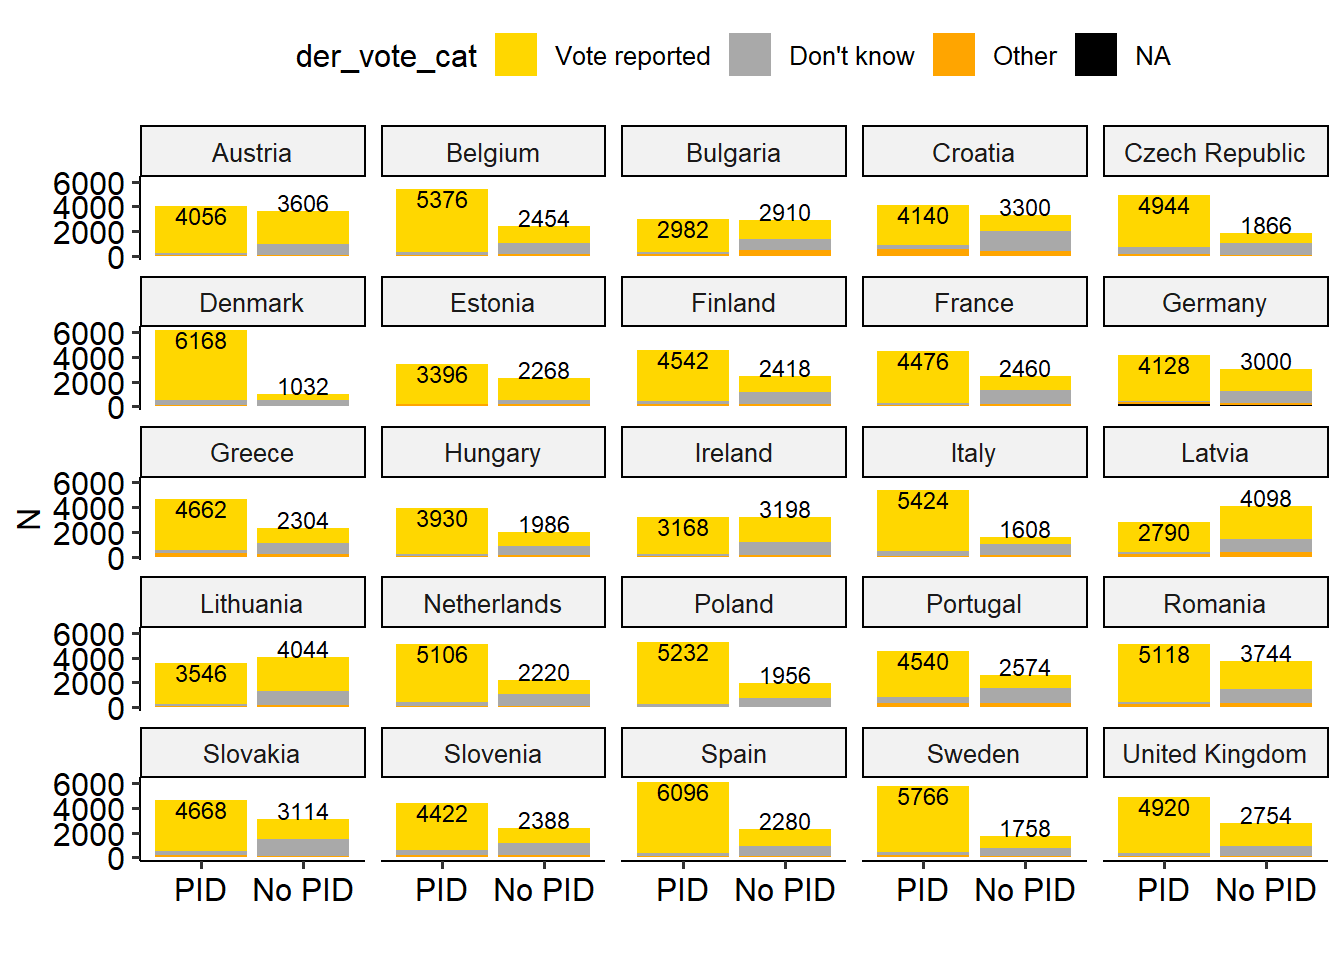

In [ ]:

df_reshaped <- eu25games2019 |>
  group_by(meta_country, der_nopid, der_vote_cat) |>
  count() |>
  ungroup()

df_reshaped


# Comparing levels of affective polarization between explicit and implicit partisans

In [ ]:

# what to do: estimate aff pol model separately or interaction term?
# preferred choice: create variable storing the different factor levels,
# allows direct comparison and inclusion of all cases in model

# wait I need 2 steps: 1 variable storing the type of partisanship,
# and 1 mapping the conjoint profiles

# create implicit/explicit partisan marker variable
eu25games2019 <- eu25games2019 |>
  mutate(
    # combined variable for partisanship
    der_partisanship = case_when(
      der_pid == "Party ID reported" ~ "1_pid_expl",
      der_pid == "No Party ID" & der_vote_cat == "Vote reported" ~ "2_pid_impl",
      der_pid == "No Party ID" & der_vote_cat == "Don't know" ~ "3_nopid",
      der_pid == "No Party ID" & der_vote_cat == "NA" ~ "3_nopid",
      der_pid == "NA" & der_vote_cat == "Vote reported" ~ "2_pid_impl",
      der_pid == "NA" & der_vote_cat == "Don't know" ~ "3_nopid",
      der_pid == "NA" & der_vote_cat == "NA" ~ "3_nopid"
    )
  )

# now let's create a new co/outpartisan variable including implicit partisans too
eu25games2019 <- eu25games2019 |>
  mutate(
    der_outpartisan_comb = case_when(
      # === EXPLICIT PID =======================================================
      # case 1: pid and control group (implies conational)
      der_partisanship == "1_pid_expl" &
        cj_trmnt == "4_somenat" &
        der_conational == "co-national" ~ "1_control_expl",
      # case 2: pid and copartisan (same)
      der_partisanship == "1_pid_expl" &
        str_detect(cj_trmnt, "partisan") &
        (ext_cj_party_pf_name == ext_q_party_id_pf_name) ~ "2_co_expl",
      # case 3: pid and outpartisan
      der_partisanship == "1_pid_expl" &
        str_detect(cj_trmnt, "partisan") &
        (ext_cj_party_pf_name != ext_q_party_id_pf_name) ~ "3_out_expl",
      # case 4: pid and eu outnational cj (hence no party shown)
      der_partisanship == "1_pid_expl" &
        !str_detect(cj_trmnt, "partisan") &
        str_detect(cj_trmnt, "eunat") ~ "97_eunat_expl",
      # case 5: pid and noneu outnational cj (hence no party shown)
      der_partisanship == "1_pid_expl" &
        !str_detect(cj_trmnt, "partisan") &
        str_detect(cj_trmnt, "somenat") ~ "98_outnat_expl",

      # === IMPLICIT PID =======================================================
      # case 4: pid and control group
      der_partisanship == "2_pid_impl" &
        cj_trmnt == "4_somenat" &
        der_conational == "co-national" ~ "4_control_impl",
      # case 5: impl pid and copartisan
      der_partisanship == "2_pid_impl" &
        str_detect(cj_trmnt, "partisan") &
        (ext_cj_party_pf_name == der_vote_combined_name) ~ "5_co_impl",
      # case 6: pid and outpartisan
      der_partisanship == "2_pid_impl" &
        str_detect(cj_trmnt, "partisan") &
        (ext_cj_party_pf_name != der_vote_combined_name) ~ "6_out_impl",
      # case 4: pid and eu outnational cj (hence no party shown)
      der_partisanship == "2_pid_impl" &
        !str_detect(cj_trmnt, "partisan") &
        str_detect(cj_trmnt, "eunat") ~ "97_eunat_impl",
      # case 5: pid and noneu outnational cj (hence no party shown)
      der_partisanship == "2_pid_impl" &
        !str_detect(cj_trmnt, "partisan") &
        str_detect(cj_trmnt, "somenat") ~ "98_outnat_impl",

      # === NO PID =============================================================
      der_partisanship == "3_nopid" &
        cj_trmnt == "4_somenat" &
        der_conational == "co-national" ~ "7_control_nopid",
      der_partisanship == "3_nopid" &
        str_detect(cj_trmnt, "partisan") ~ "8_ptycue_nopid",
      der_partisanship == "3_nopid" &
        der_conational == "out-national-EU" ~ "99_outnatEU_nopid",
      der_partisanship == "3_nopid" &
        der_conational == "out-national-non-EU" ~ "99_outnat_nopid",
      .default = NA
    )
  )

labels_der_outpartisan_comb <- eu25games2019 |>
  distinct(der_outpartisan_comb) |>
  mutate()


## Implicit vs explicit partisans distributions

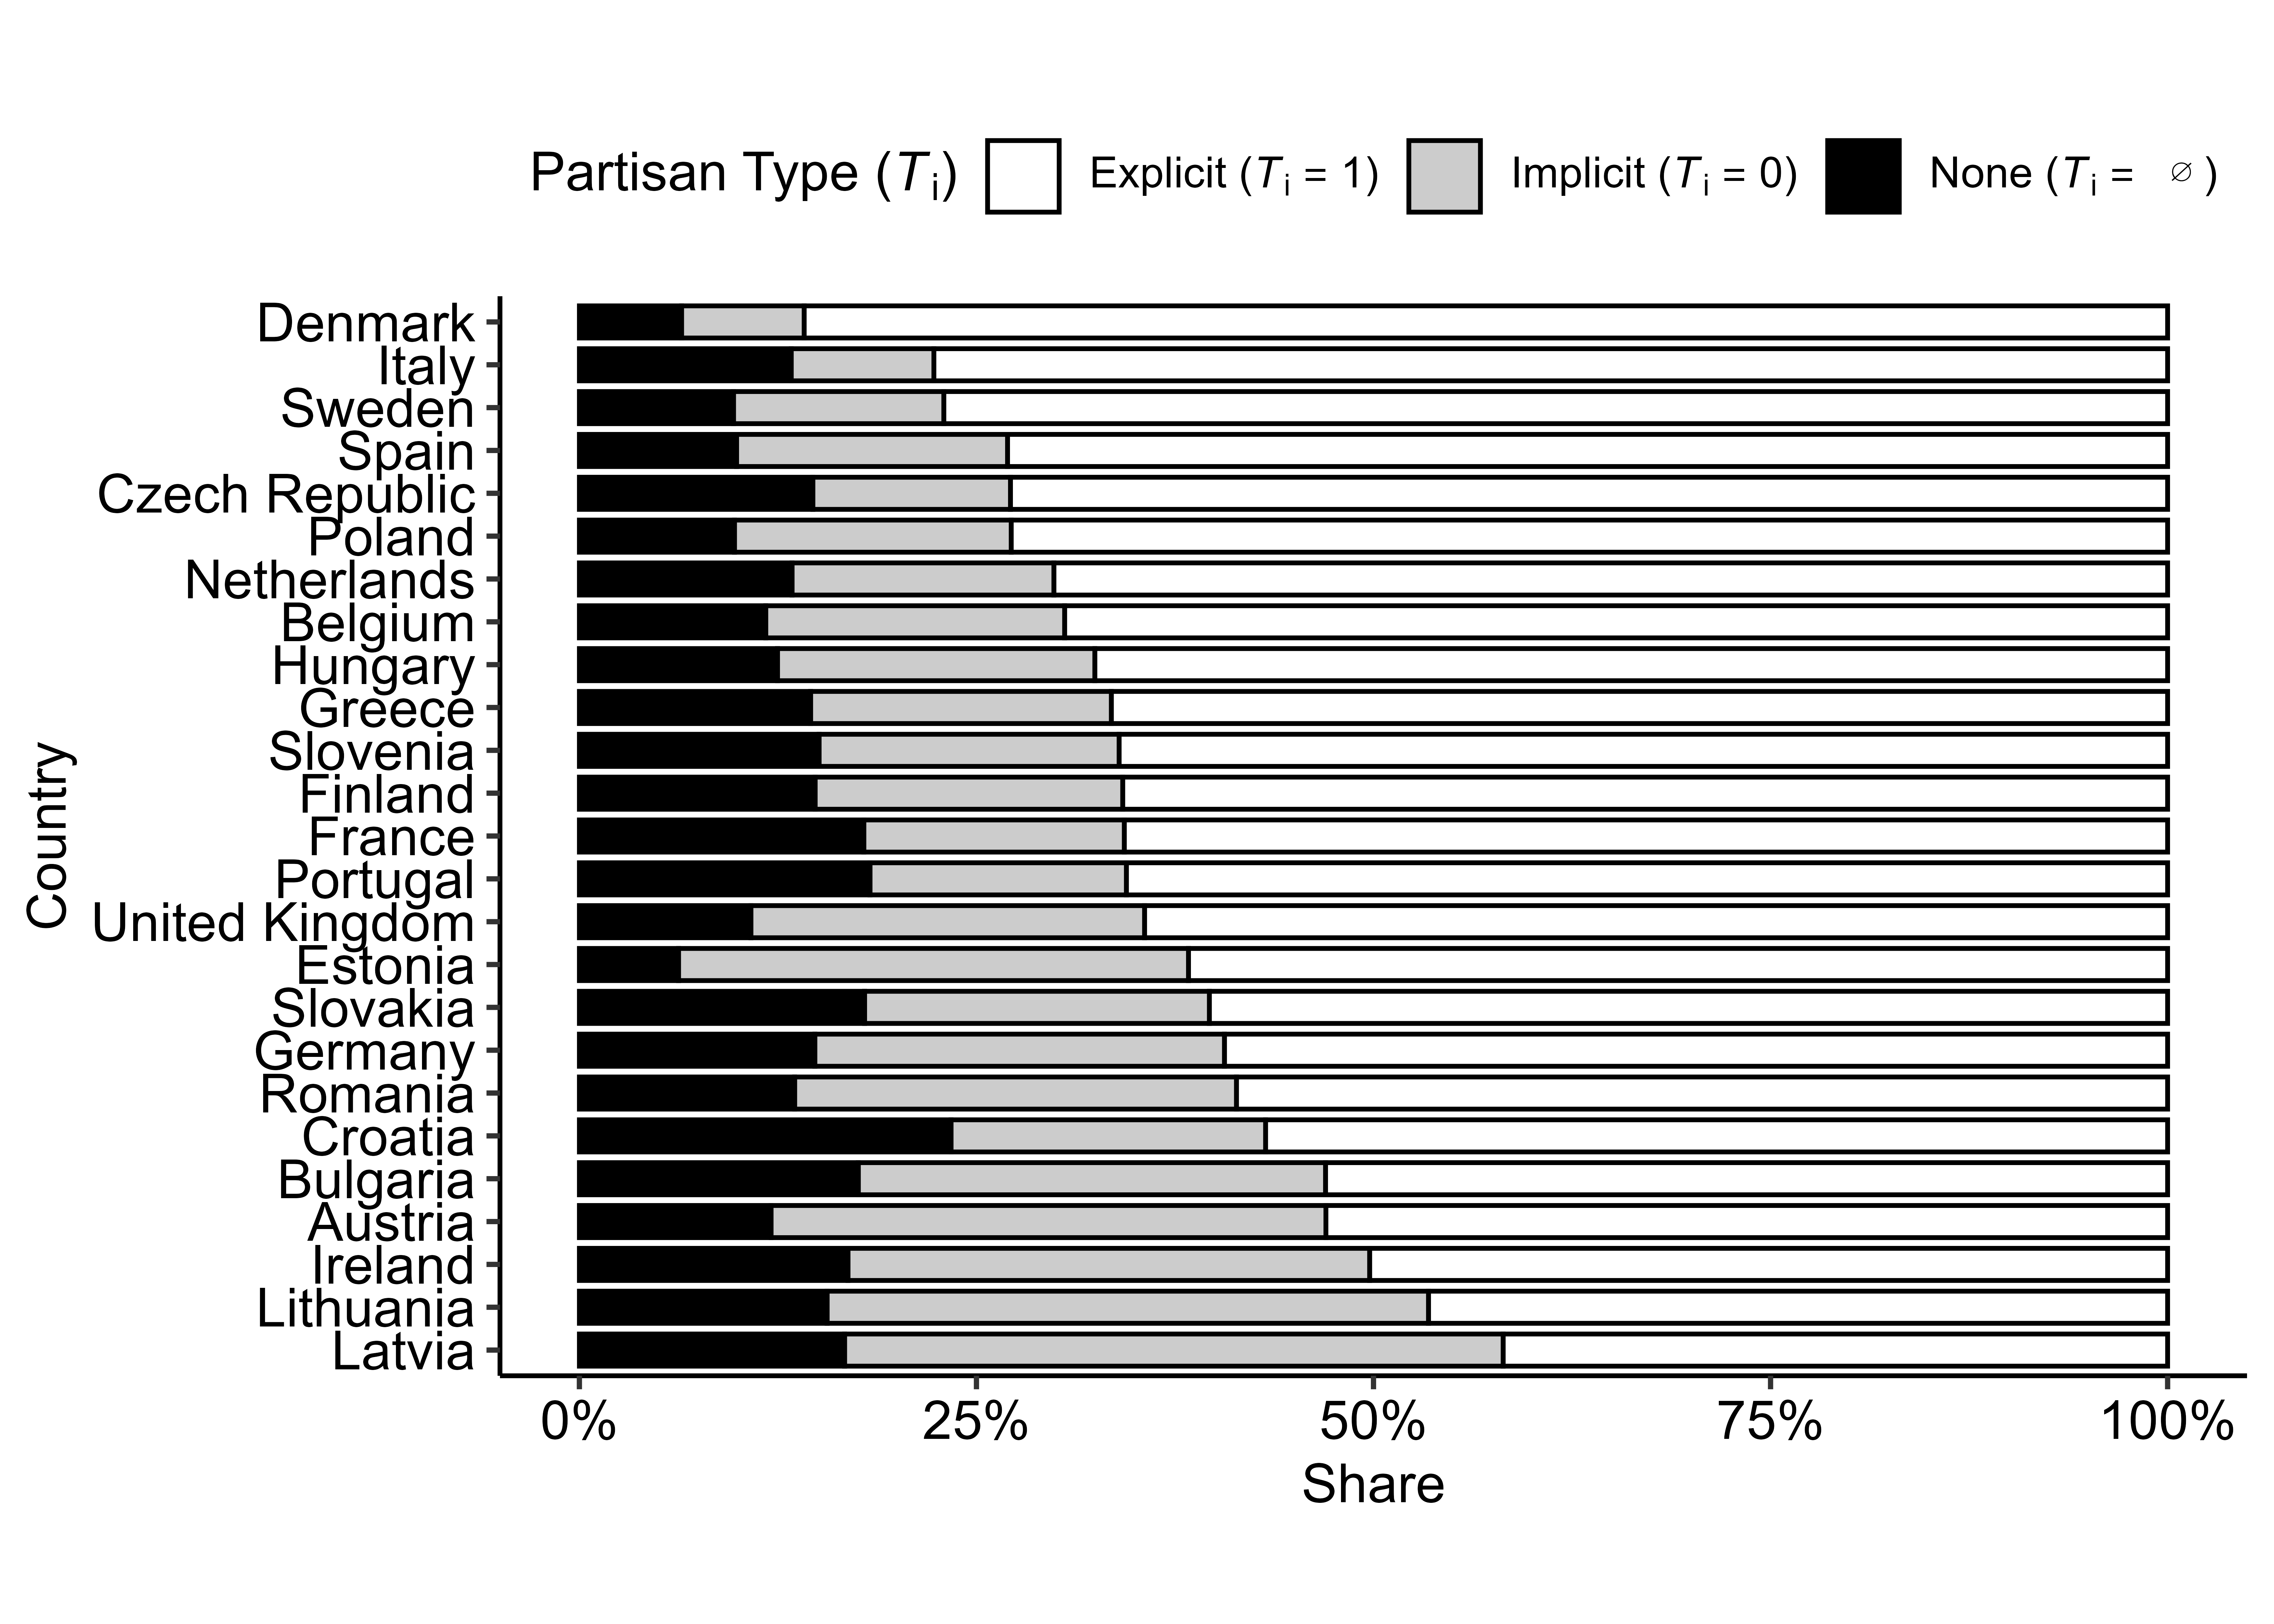

In [ ]:

toplot <- eu25games2019 |>
  select(meta_country, der_partisanship, meta_pid) |>
  distinct(meta_pid, .keep_all = T) |>
  filter(!is.na(der_partisanship)) |>
  group_by(meta_country) |>
  count(der_partisanship) |>
  mutate(
    total_n = sum(n),
    prop = n / total_n
  ) |>
  ungroup()

expl_prop <- toplot |>
  filter(der_partisanship == "1_pid_expl") |>
  select(meta_country, expl_prop = prop)

toplot <- toplot |>
  left_join(
    expl_prop,
    by = join_by(meta_country)
  ) |>
  mutate(
    meta_country = fct_reorder(meta_country, expl_prop),
    der_partisanship2 = case_when(
      der_partisanship == "1_pid_expl" ~ "Explicit",
      der_partisanship == "2_pid_impl" ~ "Implicit",
      der_partisanship == "3_nopid" ~ "None"
    )
  )

ggplot(
  toplot,
  aes(x = n, y = meta_country, fill = der_partisanship2)
) +
  geom_bar(
    stat = "identity",
    position = "fill",
    color = "black",
    width = 0.75
  ) +
  scale_fill_manual(
    values = c("white", "#CCCCCC", "black"),
    labels = c(
      bquote("Explicit (" * italic(T)[i] == 1 * ")"),
      bquote("Implicit (" * italic(T)[i] == 0 * ")"),
      expression(paste("None (", italic(T)[i] == phantom(0) * "\u2205", ")"))
    )
  ) +
  scale_x_continuous(labels = percent) +
  labs(
    x = "Share",
    y = "Country",
    fill = bquote("Partisan Type (" * italic(T)[i] * ")")
  ) +
  theme_pubr() +
  theme(
    aspect.ratio = 1 / 1.618034
  )


# Exploratory analysis of country specific ingroup and outgroup dynamics by partisan type

`summarise()` has grouped output by 'meta_country'. You can override using the
`.groups` argument.

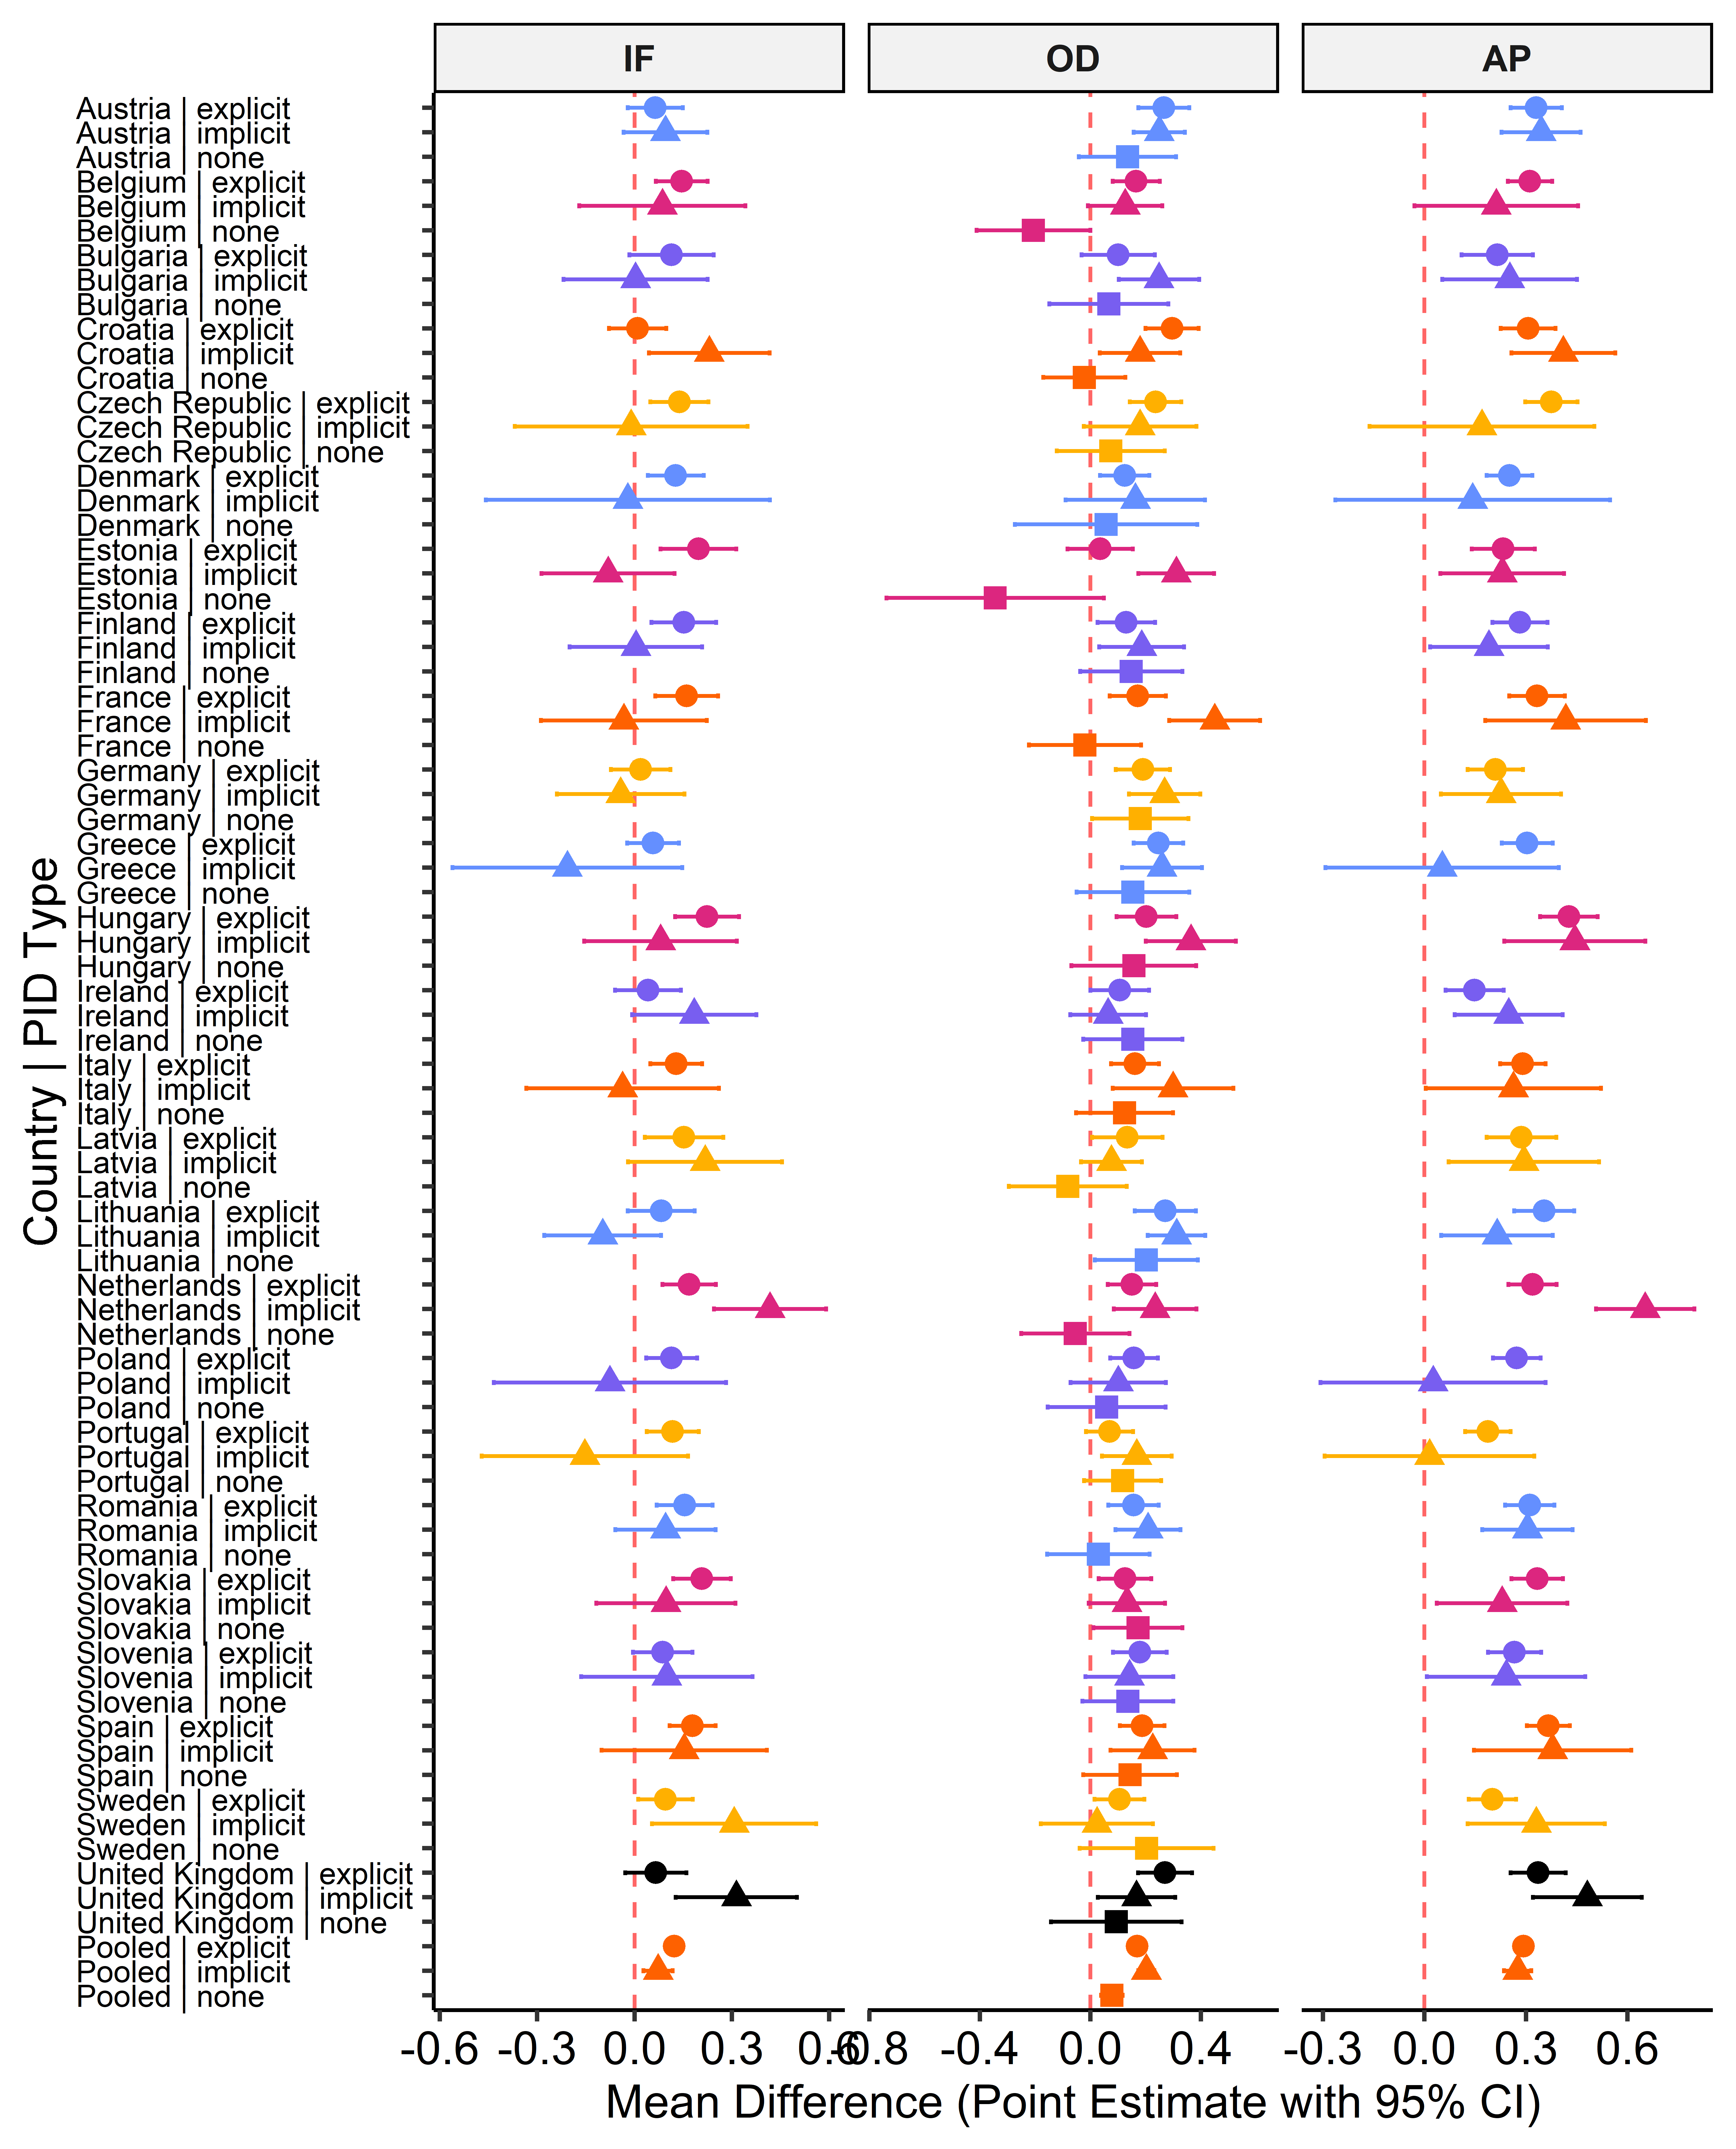

In [ ]:

eu25games2019 <- eu25games2019 |>
  mutate(
    cj_token_logged = log(cj_token + 1)
  )

token_means <- eu25games2019 |>
  filter(meta_game == "dict") |>
  filter(
    !der_outpartisan_comb %in%
      c(
        "97_eunat_expl",
        "97_eunat_impl",
        "98_outnat_expl",
        "98_outnat_impl",
        "99_outnatEU_nopid",
        "99_outnat_nopid"
      ) &
      !is.na(der_outpartisan_comb)
  ) |>
  group_by(meta_country, der_outpartisan_comb) |>
  summarise(
    m = mean(cj_token_logged),
    s = sd(cj_token_logged),
    n = n()
  ) |>
  ungroup()


`summarise()` has grouped output by 'meta_country'. You can override using the
`.groups` argument.

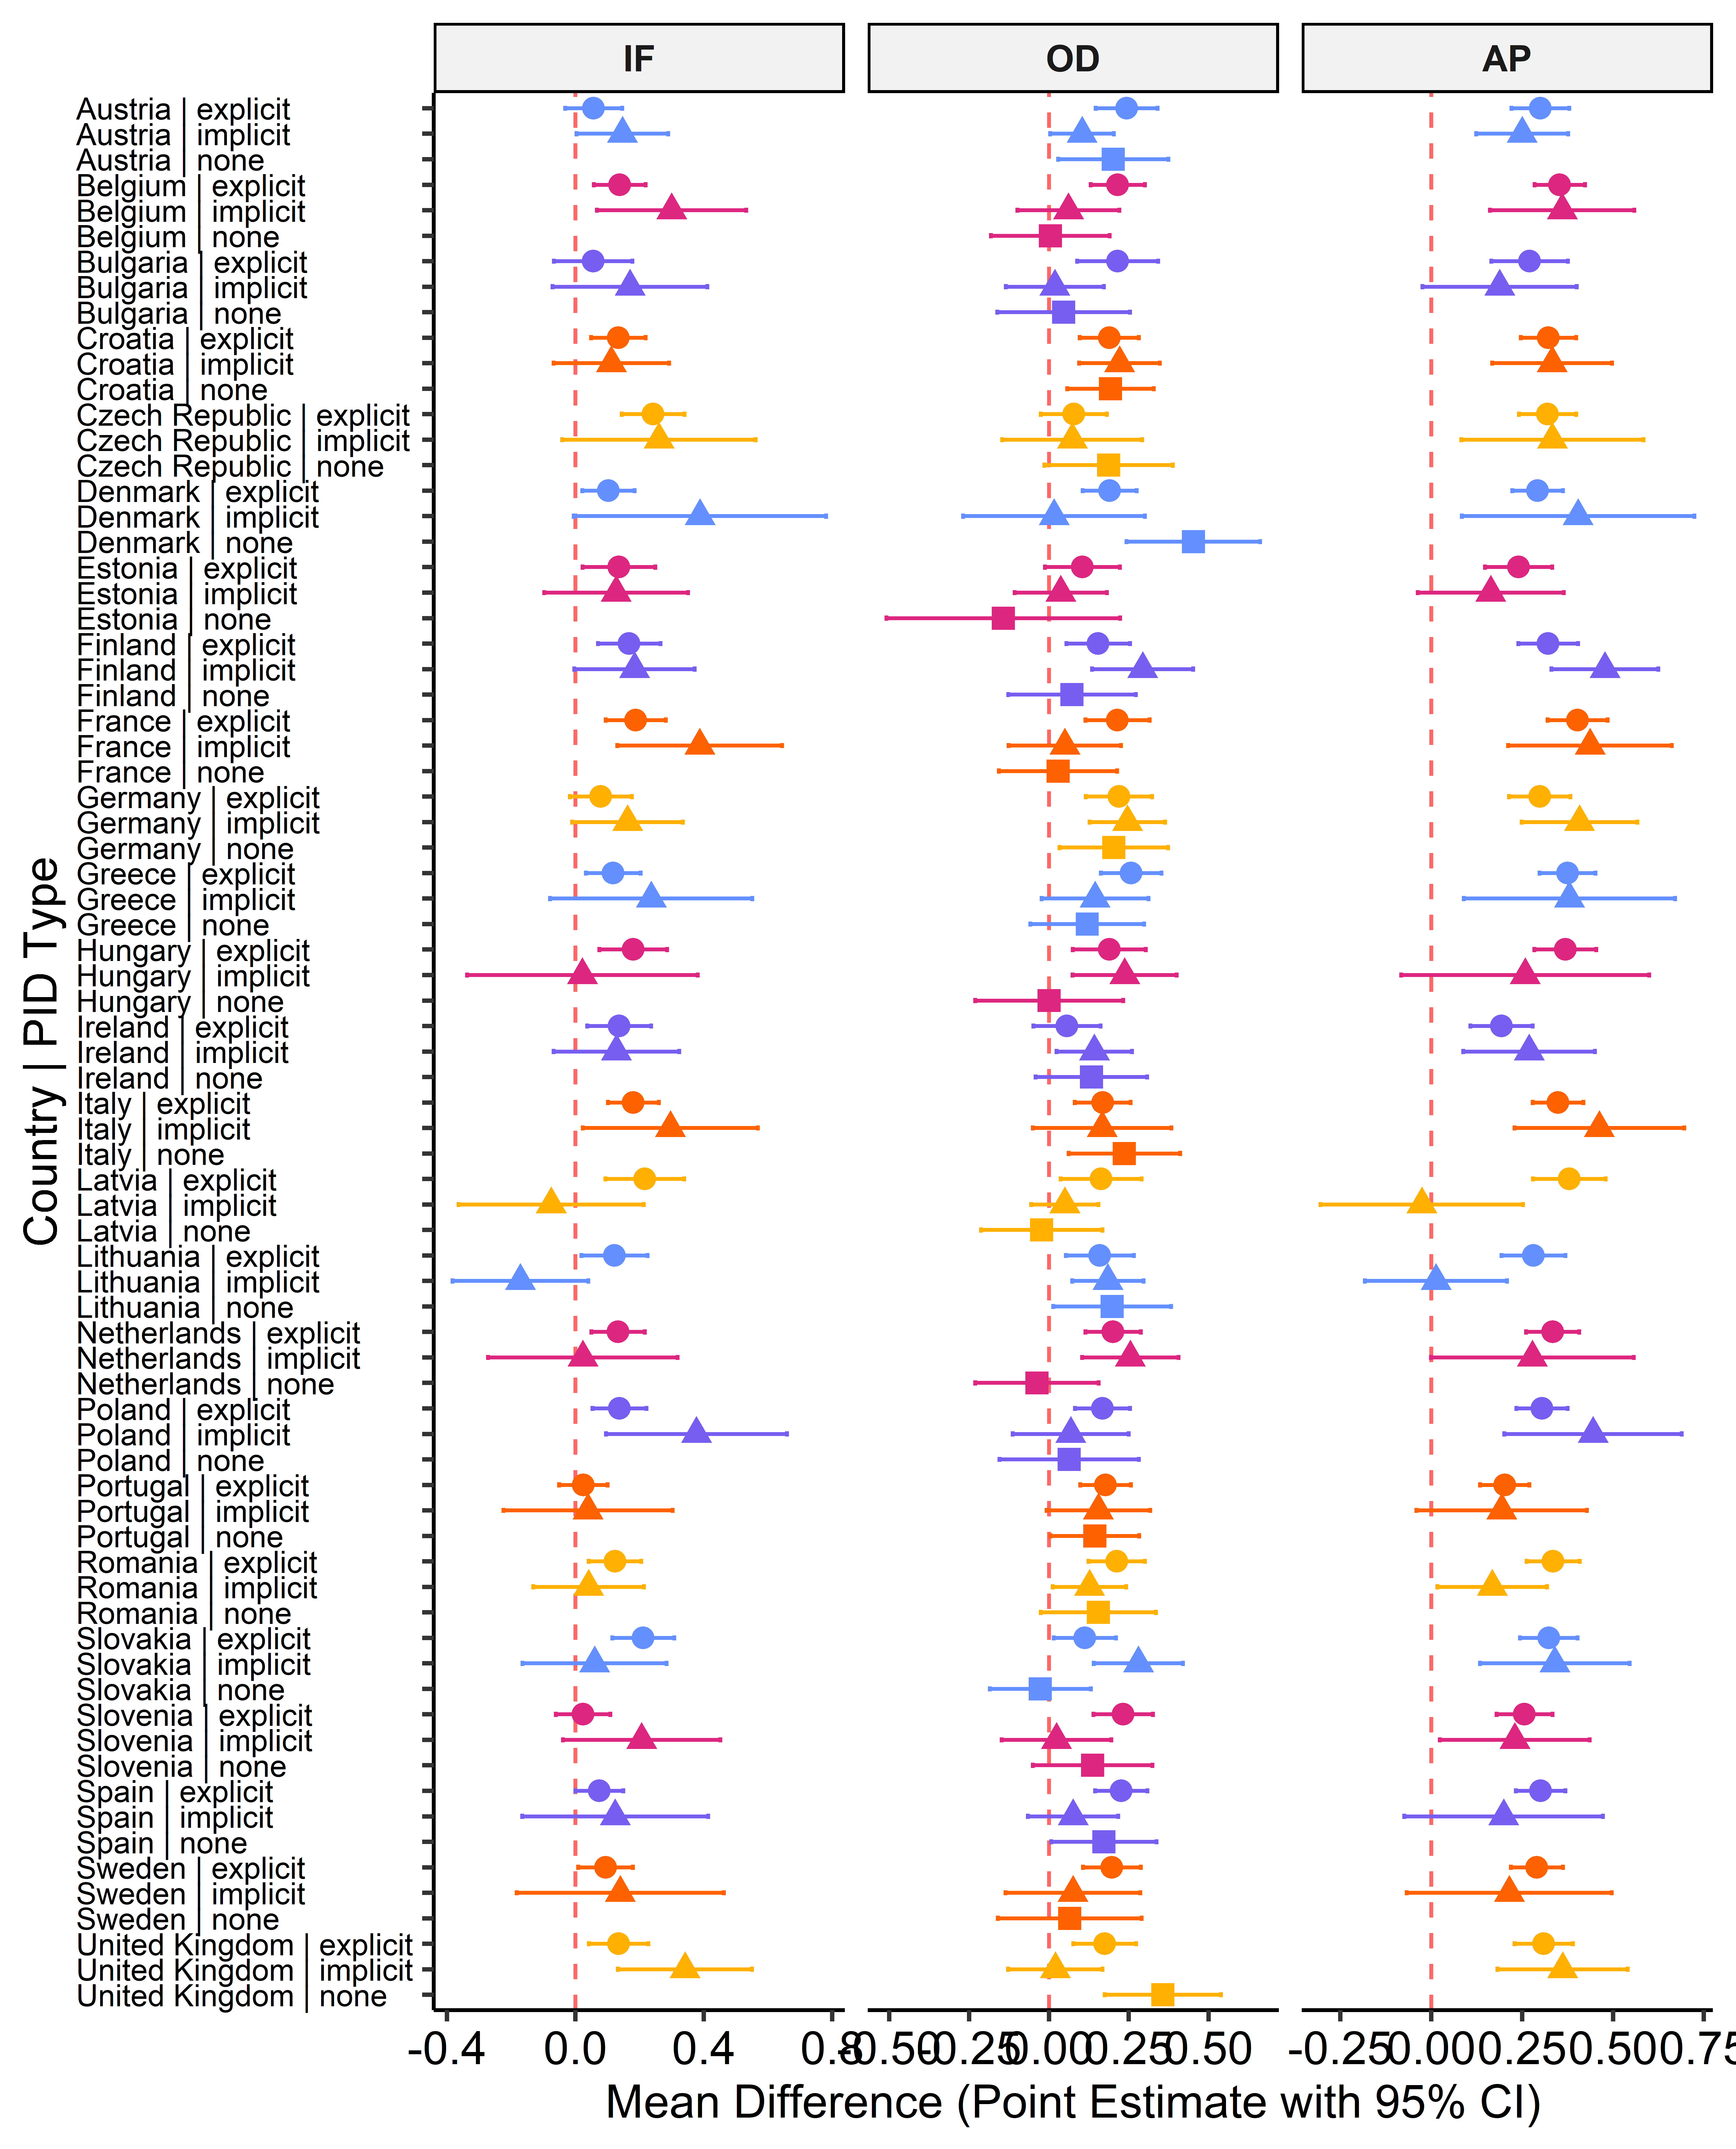

In [ ]:

eu25games2019 <- eu25games2019 |>
  mutate(
    cj_token_logged = log(cj_token + 1)
  )

token_means <- eu25games2019 |>
  filter(meta_game == "trust") |>
  filter(
    !der_outpartisan_comb %in%
      c(
        "97_eunat_expl",
        "97_eunat_impl",
        "98_outnat_expl",
        "98_outnat_impl",
        "99_outnatEU_nopid",
        "99_outnat_nopid"
      ) &
      !is.na(der_outpartisan_comb)
  ) |>
  group_by(meta_country, der_outpartisan_comb) |>
  summarise(
    m = mean(cj_token_logged),
    s = sd(cj_token_logged),
    n = n()
  ) |>
  ungroup()


In [ ]:

eu25games2019 |>
  tabyl(der_partisanship) |>
  adorn_totals()


 der_partisanship      n    percent valid_percent
       1_pid_expl 110142 0.61553852     0.6431199
       2_pid_impl  37418 0.20911387     0.2184840
          3_nopid  23702 0.13246077     0.1383961
             <NA>   7674 0.04288684            NA
            Total 178936 1.00000000     1.0000000

 der_outpartisan_comb      n     percent valid_percent
       1_control_expl  14898 0.083258819   0.086989525
            2_co_expl  30820 0.172240354   0.179958193
           3_out_expl  29366 0.164114544   0.171468277
       4_control_impl   5123 0.028630348   0.029913232
            5_co_impl   1948 0.010886574   0.011374385
           6_out_impl  18465 0.103193321   0.107817262
      7_control_nopid   3236 0.018084678   0.018895026
       8_ptycue_nopid  12878 0.071969866   0.075194731
        97_eunat_expl  19951 0.111497966   0.116494027
        97_eunat_impl   6809 0.038052712   0.039757798
       98_outnat_expl  15107 0.084426834   0.088209877
       98_outnat_impl   5073 0.028350919   0.029621282
    99_outnatEU_nopid   5936 0.033173872   0.034660345
      99_outnat_nopid   1652 0.009232351   0.009646039
                 <NA>   7674 0.042886842            NA
                Total 178936 1.000000000   1.000000000

In [ ]:

eu25games2019 |>
  tabyl(der_outpartisan_comb, meta_country) |>
  adorn_totals()


 der_outpartisan_comb Austria Belgium Bulgaria Croatia Czech Republic Denmark
       1_control_expl     517     688      371     505            644     798
            2_co_expl    1091    1442      751    1049           1401    1649
           3_out_expl    1076    1467      775    1018           1259    1636
       4_control_impl     370     208      198     176            124      79
            5_co_impl     169      69       94      58             57      29
           6_out_impl    1277     704      752     660            408     263
      7_control_nopid     119     122      122     223            138      57
       8_ptycue_nopid     499     478      497     842            517     256
        97_eunat_expl     728     971      487     665            882    1089
        97_eunat_impl     463     242      298     251            126      96
       98_outnat_expl     566     724      406     549            662     834
       98_outnat_impl     343     211      206     175          

# Generate Key Variables in the Framework: Partisan Type (T), Partisan Anchor (A), Relationship Category (R)

## Partisan Type $T$

In [ ]:

eu25games2019 <- eu25games2019 |>
  mutate(
    der_partisan_type = case_when(
      der_partisanship == "1_pid_expl" ~ 1,
      der_partisanship == "2_pid_impl" ~ 0,
      .default = NA
    )
  )


In [ ]:

eu25games2019 |>
  tabyl(der_partisan_type) |>
  adorn_totals() |>
  adorn_rounding() |>
  knitr::kable()


  der_partisan_type          n   percent   valid_percent
  ------------------- -------- --------- ---------------
  0                      37418       0.2             0.3
  1                     110142       0.6             0.7
  NA                     31376       0.2              NA
  Total                 178936       1.0             1.0


``` r

eu25games2019 |>
  tabyl(meta_country, der_partisan_type) |>
  adorn_totals()
```

       meta_country     0      1   NA_
            Austria  2622   3978  1062
            Belgium  1434   5292  1104
           Bulgaria  1548   2790  1554
            Croatia  1320   3786  2334
     Czech Republic   828   4848  1134
            Denmark   540   6006   654
            Estonia  1728   3318   618
            Finland  1284   4362  1314
             France  1110   4446  1380
            Germany  1764   4062  1302
             Greece  1194   4194  1578
            Hungary  1134   3834   948
            Ireland  2016   3084  1266
              Italy   618   5346  1068
             Latvia  2652   2676  1560
          Lithuania  2724   3348  1518
        Netherlands  1182   5028  1116
             Poland  1242   5190   756
           Portugal  1074   4386  1654
            Romania  2324   4932  1606
           Slovakia  1632   4536  1614
           Slovenia  1224   4278  1308
              Spain  1386   5934  1056
             Sweden   966   5622   936
     United Kingdom  1872   4866   936
              Total 37418 110142 31376

## Partisan Anchor $A$

In [ ]:

# think of it as partisan ingroup

eu25games2019 <- eu25games2019 |>
  mutate(
    der_partisan_anchor = case_when(
      der_pid == "Party ID reported" ~ ext_q_party_id_pf_name,
      der_pid == "No Party ID" &
        der_vote_cat == "Vote reported" ~ der_vote_combined_name
    )
  )

# how many anchors in data?
eu25games2019 |>
  distinct(der_partisan_anchor) |>
  na.omit() |>
  nrow()


[1] 374

[1] 374

``` r

eu25games2019 |>
  filter(meta_country == "Austria") |>
  tabyl(der_partisan_anchor) |>
  adorn_totals() |>
  adorn_rounding()
```

                                    der_partisan_anchor    n percent valid_percent
                     Die Grünen — Die grüne Alternative  834     0.1           0.1
                         EU-Austrittspartei (EUAUS)[og]   42     0.0           0.0
     EUROPA Jetzt – Initiative Johannes Voggenhuber[og]   60     0.0           0.0
                       Freiheitliche Partei Österreichs 1470     0.2           0.2
             KPÖ Plus – European Left, offene Liste[og]   60     0.0           0.0
                      Kommunistische Partei Österreichs   84     0.0           0.0
                                       Liste Peter Pilz   78     0.0           0.0
                             NEOS — Das Neue Österreich  696     0.1           0.1
                                            Piraten[og]   30     0.0           0.0
                 Sozialdemokratische Partei Österreichs 1620     0.2           0.2
                            Österreichische Volkspartei 1626     0.2           0.2
                                                   <NA> 1062     0.1            NA
                                                  Total 7662     1.0           1.0

``` r

eu25games2019 |>
  filter(meta_country == "Austria") |>
  tabyl(der_partisan_anchor, der_partisan_type)
```

                                    der_partisan_anchor   0    1  NA_
                     Die Grünen — Die grüne Alternative 390  444    0
                         EU-Austrittspartei (EUAUS)[og]   0   42    0
     EUROPA Jetzt – Initiative Johannes Voggenhuber[og]  60    0    0
                       Freiheitliche Partei Österreichs 504  966    0
                      Kommunistische Partei Österreichs   0   84    0
             KPÖ Plus – European Left, offene Liste[og]  60    0    0
                                       Liste Peter Pilz   0   78    0
                             NEOS — Das Neue Österreich 474  222    0
                            Österreichische Volkspartei 576 1050    0
                                            Piraten[og]   0   30    0
                 Sozialdemokratische Partei Österreichs 558 1062    0
                                                   <NA>   0    0 1062

## Partisan Relationship Category $R$

In [ ]:

eu25games2019 <- eu25games2019 |>
  mutate(
    der_partisan_relationship = case_when(
      # control group (no partisan cue but still conational)
      cj_trmnt == "4_somenat" &
        der_conational == "co-national" ~ "None",
      # copartisan
      der_partisan_anchor == ext_cj_party_pf_name ~ "Co",
      # outpartisan
      der_partisan_anchor != ext_cj_party_pf_name ~ "Out"
    ),
    der_partisan_relationship = fct_relevel(der_partisan_relationship, "None")
  )


``` r

eu25games2019 |>
  tabyl(der_partisan_relationship) |>
  adorn_totals() |>
  adorn_rounding()
```

     der_partisan_relationship      n percent valid_percent
                          None  24326     0.1           0.2
                            Co  51837     0.3           0.3
                           Out  75694     0.4           0.5
                          <NA>  27079     0.2            NA
                         Total 178936     1.0           1.0

``` r

eu25games2019 |>
  tabyl(der_partisan_relationship, der_partisan_type)
```

     der_partisan_relationship     0     1   NA_
                          None  5123 14898  4305
                            Co  3046 48791     0
                           Out 29241 46453     0
                          <NA>     8     0 27071

# More wrangling worth to be saved

In [ ]:

eu25games2019 <- eu25games2019 |>
  mutate(
    meta_game_lab = case_when(
      meta_game == "dict" ~ "Dictator",
      meta_game == "trust" ~ "Trust",
      .default = NA
    )
  )

eu25games2019 |>
  tabyl(meta_game, meta_game_lab)


 meta_game Dictator Trust
      dict    89466     0
     trust        0 89470

# Save dataset ready for estimation

In [ ]:

save(
  eu25games2019,
  file = here(
    "data",
    "02_processed",
    "eu25games2019.RData"
  )
)


# Session Info

In [ ]:

session_info()


Warning in system2("quarto", "-V", stdout = TRUE, env = paste0("TMPDIR=", :
running command '"quarto"
TMPDIR=C:/Users/Tris/AppData/Local/Temp/Rtmpgxun6C/file52e045a5fc4 -V' had
status 1

─ Session info ───────────────────────────────────────────────────────────────
 setting  value
 version  R version 4.5.1 (2025-06-13 ucrt)
 os       Windows 11 x64 (build 26200)
 system   x86_64, mingw32
 ui       RTerm
 language (EN)
 collate  English_United States.utf8
 ctype    English_United States.utf8
 tz       Europe/Berlin
 date     2026-01-09
 pandoc   3.6.3 @ c:\\Program Files\\Positron\\resources\\app\\quarto\\bin\\tools/ (via rmarkdown)
 quarto   NA @ C:\\PROGRA~1\\Positron\\RESOUR~1\\app\\quarto\\bin\\quarto.exe

─ Packages ───────────────────────────────────────────────────────────────────
 ! package        * version  date (UTC) lib source
 P abind            1.4-8    2024-09-12 [?] CRAN (R 4.5.0)
 P backports        1.5.0    2024-05-23 [?] CRAN (R 4.5.0)
   bayesplot        1.15.0   2025-12-12 [1] CRAN (R 4.5.2)
   bridgesampling   1.2-1    2025-11-19 [1] CRAN (R 4.5.2)
   brms           * 2.23.0   2025-09-09 [1] CRAN (R 4.5.2)
   Brobdingnag      1.2-9    2022-10-19 [1]

# Render Time

In [ ]:

end_time <- Sys.time()

rendering_time <- end_time - start_time

message(paste(
  "Document rendered in:",
  round(as.numeric(rendering_time, units = "secs"), 2),
  "seconds.
"
))


Document rendered in: 31.38 seconds.

```` markdown
---
title: |
  CSAP Code Notebook 01
subtitle: |
  Creating Variables, Cleaning and Tidying Data
date: last-modified
date-format: MMMM D, YYYY
format:
  html:
    toc: true
    code-fold: true
    code-tools: true
    embed-resources: true
execute:
  echo: true
  warning: true
  eval: true
  message: true
---

# Setup

quarto-executable-code-5450563D

```r
#| label: setup

# To track render duration
start_time <- Sys.time()


# Install and load required packages
p_required <- c(
  "tidyverse", #dplyr, ggplot, tibbles etc
  "here", # relative and sys agnostic file paths
  "janitor", # easy wrangling and exploratory tables
  "knitr", # kable()
  "ggpubr", # ggplot themes and shortcuts
  "scales",
  "viridis",
  "brms", # bayesian regression models using stan
  "sessioninfo" # documentation
)
packages <- rownames(installed.packages())
p_to_install <- p_required[!(p_required %in% packages)]
if (length(p_to_install) > 0) {
  pak::pkg_install(p_to_install)
}
sapply(p_required, require, character.only = TRUE)
rm(p_required, p_to_install, packages)
```

quarto-executable-code-5450563D

```r
#| label: load-data

# Load Data
load(here("data", "01_raw", "eu25games2019.RData"))

```

# Exploratory Analysis: Cross-National Distribution of Partisan Attachement


We have:
  - Partisan Attachement (`q_party_id`)
  - Vote Intention (`q_vote_intention``q_vote_intention_hypo`)
  - Reported Vote Choice (`q_voted_party`, `q_voted_party_hypo`)
  - Reported Vote Choice 2014 (`q_voted_party_2014`)

- Given our primary interest in explicit and implicit attachement, we pursue a maximizing strategy (i.e., for example, collapsing `vote_intention` and `vote_intention_hypo`)

quarto-executable-code-5450563D

```r
#| label: party-variables-aggregated

eu25games2019 <- eu25games2019 |>
  # Create aggregated/combined variables
  mutate(
    der_vote_combined_name = coalesce(
      ext_q_vote_intention_pf_name,
      ext_q_vote_intention_hypo_pf_name,
      ext_q_voted_party_pf_name,
      ext_q_voted_party_hypo_pf_name
    ),
    der_vote_combined_id = coalesce(
      ext_q_vote_intention_pf_id,
      ext_q_vote_intention_hypo_pf_id,
      ext_q_voted_party_pf_id,
      ext_q_voted_party_hypo_pf_id
    ),
    der_vote_cat = case_when(
      der_vote_combined_name == "other" ~ "Other",
      der_vote_combined_name == "dont-know" ~ "Don't know",
      is.na(der_vote_combined_name) ~ "NA",
      .default = "Vote reported"
    ),
    der_pid = case_when(
      ext_q_party_id_pf_name == "none" ~ "No Party ID",
      ext_q_party_id_pf_name == "other" ~ "Other",
      is.na(ext_q_party_id_pf_name) ~ "NA",
      .default = "Party ID reported"
    )
  ) |>
  # Convert to factors and sort by frequency
  mutate(
    across(
      c(der_vote_combined_name, der_vote_combined_id, der_vote_cat, der_pid),
      ~ fct_infreq(as.character(.x))
    )
  )

```

# Distribution of implicit and explicit partisans pooled and across countries

quarto-executable-code-5450563D

```r
#| label: tbl-distr-partyid-pooled
#| tbl-cap: "Distribution of reported partisan attachement (*explicit partisan identity*) in the pooled sample."

eu25games2019 |>
  tabyl(der_pid) |>
  adorn_totals() |>
  kable(
    digits = 2,
    booktabs = T
  )

```

quarto-executable-code-5450563D

```r
#| label: tbl-distr-vote-pooled
#| tbl-cap: "Distribution of reported vote intention and choice (*implicit partisan identity*) in the pooled sample."

eu25games2019 |>
  tabyl(der_vote_cat) |>
  adorn_totals() |>
  kable(
    digits = 2,
    booktabs = T
  )

```


quarto-executable-code-5450563D

```r
#| label: tbl-cross-vote-pid-pooled
#| tbl-cap: "Distribution of explicit and implicit partisan identities in the pooled sample."

eu25games2019 |>
  tabyl(der_pid, der_vote_cat) |>
  adorn_totals() |>
  kable(
    digits = 2,
    booktabs = T
  )

```

quarto-executable-code-5450563D

```r
#| label: tbl-distr-partyid-country
#| tbl-cap: "Distribution of reported partisan attachement (*explicit partisan identity*) by country."

eu25games2019 |>
  tabyl(der_pid, meta_country) |>
  adorn_totals() |>
  kable(
    digits = 2,
    booktabs = T
  )

```

quarto-executable-code-5450563D

```r
#| label: tbl-distr-vote-country
#| tbl-cap: "Distribution of reported vote intention and choice (*implicit partisan identity*) in the pooled sample."

eu25games2019 |>
  tabyl(der_vote_cat, meta_country) |>
  adorn_totals() |>
  kable(
    digits = 2,
    booktabs = T
  )

```


quarto-executable-code-5450563D

```r
#| label: tbl-cross-vote-pid-country
#| tbl-cap: "Distribution of explicit and implicit partisan identities by country."

eu25games2019 |>
  tabyl(der_pid, der_vote_cat, meta_country) |>
  adorn_totals()

```



# Overview of data distribution

Respondents -> Party ID -> Vote report

In words, respondents either report a partisan identity (i.e., a felt attachement to a political party) or they deny the presence of such feelings.

## The number of respondents

quarto-executable-code-5450563D

```r
#| label: tbl-n-resp

eu25games2019 |>
  distinct(meta_pid) |>
  nrow()
```

## The numer of respondents reporting PID vs not

quarto-executable-code-5450563D

```r
#| label: tbl-n-resp-pid

eu25games2019 |>
  distinct(meta_pid, .keep_all = T) |>
  count(der_pid)
```

## The number of non-identifiers who report a vote (vs not)

quarto-executable-code-5450563D

```r
#| label: tbl-n-resp-nopid-vote

eu25games2019 |>
  distinct(meta_pid, .keep_all = T) |>
  filter(der_pid == "No Party ID") |>
  count(der_vote_cat)
```

## The number of identifiers who report a vote (vs not)

quarto-executable-code-5450563D

```r
#| label: tbl-n-resp-pid-vote

eu25games2019 |>
  distinct(meta_pid, .keep_all = T) |>
  filter(der_pid == "Party ID reported") |>
  count(der_vote_cat)
```

## The number of identifiers who reported vote identical to PID

quarto-executable-code-5450563D

```r
#| label: tbl-n-resp-pid-vote-same

eu25games2019 |>
  distinct(meta_pid, .keep_all = T) |>
  filter(der_pid == "Party ID reported") |>
  mutate(
    pid_equal_vote_name = if_else(
      der_vote_combined_name == ext_q_party_id_pf_name,
      1,
      0
    )
  ) |>
  count(pid_equal_vote_name)

# but accounting for unknown and dont-know answers yields
eu25games2019 |>
  distinct(meta_pid, .keep_all = T) |>
  filter(
    der_pid == "Party ID reported",
    der_vote_combined_name != "unknown",
    der_vote_combined_name != "dont-know"
  ) |>
  mutate(
    pid_equal_vote_name = if_else(
      der_vote_combined_name == ext_q_party_id_pf_name,
      1,
      0
    ),
    pid_equal_vote_id = if_else(
      der_vote_combined_id == ext_q_party_id_pf_id,
      1,
      0
    )
  ) |>
  count(pid_equal_vote_name, pid_equal_vote_id)


```


quarto-executable-code-5450563D

```r
#| label: tbl-pid-vote-corr2

eu25games2019 |>
  distinct(meta_pid, .keep_all = T) |>
  filter(der_pid == "Party ID reported") |>
  mutate(
    pid_equal_vote_id = if_else(
      der_vote_combined_id == ext_q_party_id_pf_id,
      1,
      0
    )
  ) |>
  count(pid_equal_vote_id)
```

quarto-executable-code-5450563D

```r
eu25games2019 <- eu25games2019 |>
  mutate(
    pid_equal_vote_id = case_when(
      der_pid == "Party ID reported" &
        der_vote_cat == "Vote reported" &
        der_vote_combined_id == ext_q_party_id_pf_id ~ 1,
      der_pid == "Party ID reported" &
        der_vote_cat == "Vote reported" &
        der_vote_combined_id != ext_q_party_id_pf_id ~ 0,
      .default = NA
    ),
    pid_equal_vote_name = case_when(
      der_pid == "Party ID reported" &
        der_vote_cat == "Vote reported" &
        der_vote_combined_name == ext_q_party_id_pf_name ~ 1,
      der_pid == "Party ID reported" &
        der_vote_cat == "Vote reported" &
        der_vote_combined_name != ext_q_party_id_pf_name ~ 0,
      .default = NA
    )
  )

# manually recode some instances where the casewhen check above yielded different but inspection revealed its basically the same party
eu25games2019 <- eu25games2019 |>
  mutate(
    # New column using case_when for manual line-by-line recoding
    pid_equal_vote_name2 = case_when(
      # Case 1: Party names are already identical (from pid_equal_vote_name = 1)
      pid_equal_vote_name == 1 ~ 1,

      # Case 2: Polish Koalicja Obywatelska (PO, SLD, Spring, PSL, Nowoczesna)
      pid_equal_vote_name == 0 &
        ext_q_party_id_pf_name %in%
          c(
            "Platforma Obywatelska",
            "Sojusz Lewicy Demokratycznej",
            "Spring",
            "Polskie Stronnictwo Ludowe",
            "Nowoczesna"
          ) &
        der_vote_combined_name == "Koalicja Obywatelska" ~ 1,

      # Case 3: Spanish Unidas Podemos (Podemos, Izquierda Unida)
      pid_equal_vote_name == 0 &
        ext_q_party_id_pf_name %in%
          c(
            "Podemos",
            "Izquierda Unida"
          ) &
        der_vote_combined_name == "Unidas Podemos" ~ 1,

      # Case 4: Dutch ChristenUnie — SGP
      pid_equal_vote_name == 0 &
        ext_q_party_id_pf_name %in%
          c(
            "ChristenUnie",
            "Staatkundig Gereformeerde Partij"
          ) &
        der_vote_combined_name ==
          "ChristenUnie — Staatkundig Gereformeerde Partij" ~ 1,

      # Case 5: Hungarian Fidesz — KDNP (using grepl for robustness against long name)
      pid_equal_vote_name == 0 &
        ext_q_party_id_pf_name %in%
          c(
            "Fidesz — Magyar Polgári Szövetség",
            "Kereszténydemokrata Néppárt"
          ) &
        grepl(
          "Fidesz — KDNP pártszövetség",
          der_vote_combined_name,
          fixed = TRUE
        ) ~ 1,

      # Case 6: Polish Konfederacja Wolność i Niepodległość (KNP, KORWiN, Kukiz'15)
      pid_equal_vote_name == 0 &
        ext_q_party_id_pf_name %in%
          c(
            "Kongres Nowej Prawicy",
            "Koalicja Odnowy Rzeczypospolitej Wolność i Nadzieja KORWiN",
            "Kukiz'15"
          ) &
        der_vote_combined_name == "Konfederacja Wolność i Niepodległość" ~ 1,

      # Case 7: Latvian Attīstībai/Par!
      pid_equal_vote_name == 0 &
        ext_q_party_id_pf_name == "Kustība Par!" &
        der_vote_combined_name == "Attīstībai/Par!" ~ 1,

      # Case 8: French LREM/Renaissance
      pid_equal_vote_name == 0 &
        ext_q_party_id_pf_name == "Mouvement démocrate" &
        der_vote_combined_name == "La République En Marche! / Renaissance" ~ 1,

      # Case 9: Catalan JxCat (Partit Demòcrata Europeu Català)
      pid_equal_vote_name == 0 &
        ext_q_party_id_pf_name == "Partit Demòcrata Europeu Català" &
        der_vote_combined_name ==
          "Junts per Catalunya — Partit Demòcrata Europeu Català" ~ 1,

      # Default: All other cases (where pid_equal_vote_name was 0 and no manual case matched)
      TRUE ~ pid_equal_vote_name
    )
  )

eu25games2019 |>
  distinct(meta_pid, .keep_all = T) |>
  count(pid_equal_vote_name2)
```

## Schematic overview

quarto-executable-code-5450563D

```mermaid
flowchart TD
    A(Respondents <br> N = 29,827) --> B(No Party ID <br> N = 10,880) 
    A(Respondents <br> N = 29,827) --> C(Party ID <br> N = 18,357)

    B --> D(No Vote <br> N = 3,900)
    B --> E(Vote <br> N = 6,234)

    C --> F(No Vote <br> N = 1,030)
    C --> G(Vote <br> N = 16,917)

    G --> H(Same as PID <br> N = 13,220)
    G --> I(Diff from PID <br> N = 3,697)
```

## Figures

quarto-executable-code-5450563D

```r
#| label: fig-distr-partisans
#| fig-cap: "Distribution of Reported Partisan Affiliation and Vote Choice/Intention across included European countries."

df_reshaped <- eu25games2019 |>
  group_by(meta_country, der_nopid, der_vote_cat) |>
  count() |>
  ungroup()

df_reshaped

total_counts <- df_reshaped |>
  group_by(meta_country, der_nopid) |>
  summarise(n = sum(n), .groups = "drop") |>
  mutate(
    nopid2 = if_else(der_nopid == 1, "No PID", "PID"),
    toprint = paste0(
      nopid2,
      "\n",
      as.character(n)
    ),
    toprint2 = as.character(n)
  )

ggplot(df_reshaped, aes(x = as.factor(der_nopid), y = n, fill = der_vote_cat)) +
  geom_col() +
  geom_text(
    data = total_counts,
    aes(label = toprint2, fill = "black"),
    vjust = if_else(
      total_counts$der_nopid == 1,
      0,
      1
    ),
    size = 3
  ) +
  facet_wrap(~meta_country) +
  labs(y = "N", x = "") +
  scale_x_discrete(labels = c("0" = "PID", "1" = "No PID")) +
  scale_fill_manual(
    values = c(
      "Don't know" = "darkgray",
      "NA" = "black",
      "Other" = "orange",
      "Vote reported" = "gold"
    )
  ) +
  theme_pubr()
```

# Comparing levels of affective polarization between explicit and implicit partisans


quarto-executable-code-5450563D

```r
#| label: main-iv

# what to do: estimate aff pol model separately or interaction term?
# preferred choice: create variable storing the different factor levels,
# allows direct comparison and inclusion of all cases in model

# wait I need 2 steps: 1 variable storing the type of partisanship,
# and 1 mapping the conjoint profiles

# create implicit/explicit partisan marker variable
eu25games2019 <- eu25games2019 |>
  mutate(
    # combined variable for partisanship
    der_partisanship = case_when(
      der_pid == "Party ID reported" ~ "1_pid_expl",
      der_pid == "No Party ID" & der_vote_cat == "Vote reported" ~ "2_pid_impl",
      der_pid == "No Party ID" & der_vote_cat == "Don't know" ~ "3_nopid",
      der_pid == "No Party ID" & der_vote_cat == "NA" ~ "3_nopid",
      der_pid == "NA" & der_vote_cat == "Vote reported" ~ "2_pid_impl",
      der_pid == "NA" & der_vote_cat == "Don't know" ~ "3_nopid",
      der_pid == "NA" & der_vote_cat == "NA" ~ "3_nopid"
    )
  )

# now let's create a new co/outpartisan variable including implicit partisans too
eu25games2019 <- eu25games2019 |>
  mutate(
    der_outpartisan_comb = case_when(
      # === EXPLICIT PID =======================================================
      # case 1: pid and control group (implies conational)
      der_partisanship == "1_pid_expl" &
        cj_trmnt == "4_somenat" &
        der_conational == "co-national" ~ "1_control_expl",
      # case 2: pid and copartisan (same)
      der_partisanship == "1_pid_expl" &
        str_detect(cj_trmnt, "partisan") &
        (ext_cj_party_pf_name == ext_q_party_id_pf_name) ~ "2_co_expl",
      # case 3: pid and outpartisan
      der_partisanship == "1_pid_expl" &
        str_detect(cj_trmnt, "partisan") &
        (ext_cj_party_pf_name != ext_q_party_id_pf_name) ~ "3_out_expl",
      # case 4: pid and eu outnational cj (hence no party shown)
      der_partisanship == "1_pid_expl" &
        !str_detect(cj_trmnt, "partisan") &
        str_detect(cj_trmnt, "eunat") ~ "97_eunat_expl",
      # case 5: pid and noneu outnational cj (hence no party shown)
      der_partisanship == "1_pid_expl" &
        !str_detect(cj_trmnt, "partisan") &
        str_detect(cj_trmnt, "somenat") ~ "98_outnat_expl",

      # === IMPLICIT PID =======================================================
      # case 4: pid and control group
      der_partisanship == "2_pid_impl" &
        cj_trmnt == "4_somenat" &
        der_conational == "co-national" ~ "4_control_impl",
      # case 5: impl pid and copartisan
      der_partisanship == "2_pid_impl" &
        str_detect(cj_trmnt, "partisan") &
        (ext_cj_party_pf_name == der_vote_combined_name) ~ "5_co_impl",
      # case 6: pid and outpartisan
      der_partisanship == "2_pid_impl" &
        str_detect(cj_trmnt, "partisan") &
        (ext_cj_party_pf_name != der_vote_combined_name) ~ "6_out_impl",
      # case 4: pid and eu outnational cj (hence no party shown)
      der_partisanship == "2_pid_impl" &
        !str_detect(cj_trmnt, "partisan") &
        str_detect(cj_trmnt, "eunat") ~ "97_eunat_impl",
      # case 5: pid and noneu outnational cj (hence no party shown)
      der_partisanship == "2_pid_impl" &
        !str_detect(cj_trmnt, "partisan") &
        str_detect(cj_trmnt, "somenat") ~ "98_outnat_impl",

      # === NO PID =============================================================
      der_partisanship == "3_nopid" &
        cj_trmnt == "4_somenat" &
        der_conational == "co-national" ~ "7_control_nopid",
      der_partisanship == "3_nopid" &
        str_detect(cj_trmnt, "partisan") ~ "8_ptycue_nopid",
      der_partisanship == "3_nopid" &
        der_conational == "out-national-EU" ~ "99_outnatEU_nopid",
      der_partisanship == "3_nopid" &
        der_conational == "out-national-non-EU" ~ "99_outnat_nopid",
      .default = NA
    )
  )

labels_der_outpartisan_comb <- eu25games2019 |>
  distinct(der_outpartisan_comb) |>
  mutate()

```

## Implicit vs explicit partisans distributions

```{r, dev='ragg_png'}
#| label: fig-impl-expl-distribution
#| fig-cap: "Distribution of partisan types, by country. Stacked horizontal bars show the within-country share (\\%) of three partisan types: explicit partisans (respondents who reported a subjective attachement to a party, $T_i=1$), implicit partisans (respondents who reported no attachement but did report a vote preference or intention, $T_i=0$), and respondents who reported neither (none, $T_i = \\emptyset$). Percentages sum to 100\\% within each country, with country samples containing about $1,100$ respondents each (detailed numbers are reported in appendix section X)."
#| fig-dpi: 500

toplot <- eu25games2019 |>
  select(meta_country, der_partisanship, meta_pid) |>
  distinct(meta_pid, .keep_all = T) |>
  filter(!is.na(der_partisanship)) |>
  group_by(meta_country) |>
  count(der_partisanship) |>
  mutate(
    total_n = sum(n),
    prop = n / total_n
  ) |>
  ungroup()

expl_prop <- toplot |>
  filter(der_partisanship == "1_pid_expl") |>
  select(meta_country, expl_prop = prop)

toplot <- toplot |>
  left_join(
    expl_prop,
    by = join_by(meta_country)
  ) |>
  mutate(
    meta_country = fct_reorder(meta_country, expl_prop),
    der_partisanship2 = case_when(
      der_partisanship == "1_pid_expl" ~ "Explicit",
      der_partisanship == "2_pid_impl" ~ "Implicit",
      der_partisanship == "3_nopid" ~ "None"
    )
  )

ggplot(
  toplot,
  aes(x = n, y = meta_country, fill = der_partisanship2)
) +
  geom_bar(
    stat = "identity",
    position = "fill",
    color = "black",
    width = 0.75
  ) +
  scale_fill_manual(
    values = c("white", "#CCCCCC", "black"),
    labels = c(
      bquote("Explicit (" * italic(T)[i] == 1 * ")"),
      bquote("Implicit (" * italic(T)[i] == 0 * ")"),
      expression(paste("None (", italic(T)[i] == phantom(0) * "\u2205", ")"))
    )
  ) +
  scale_x_continuous(labels = percent) +
  labs(
    x = "Share",
    y = "Country",
    fill = bquote("Partisan Type (" * italic(T)[i] * ")")
  ) +
  theme_pubr() +
  theme(
    aspect.ratio = 1 / 1.618034
  )
```


# Exploratory analysis of country specific ingroup and outgroup dynamics by partisan type

quarto-executable-code-5450563D

```r
#| label: fig-exploratory-country-anal-dict
#| fig-cap: "Exploratory token allocation behavior by country and pid type in the dictator game: ingroup favoritism, outgroup derogation and affective polarization. The figure shows mean differences in token allocation with 95\\% confidence intervals. IF = mean(token2co) - mean(token2control), OD = mean(token2control) - mean(token2out), AP = mean(token2co) - mean(token2out)"
#| fig-dpi: 500
#| fig-width: 6.3
#| fig-height: 7.8
#| fig-pos : H

eu25games2019 <- eu25games2019 |>
  mutate(
    cj_token_logged = log(cj_token + 1)
  )

token_means <- eu25games2019 |>
  filter(meta_game == "dict") |>
  filter(
    !der_outpartisan_comb %in%
      c(
        "97_eunat_expl",
        "97_eunat_impl",
        "98_outnat_expl",
        "98_outnat_impl",
        "99_outnatEU_nopid",
        "99_outnat_nopid"
      ) &
      !is.na(der_outpartisan_comb)
  ) |>
  group_by(meta_country, der_outpartisan_comb) |>
  summarise(
    m = mean(cj_token_logged),
    s = sd(cj_token_logged),
    n = n()
  ) |>
  ungroup()

token_means_pooled <- eu25games2019 |>
  filter(meta_game == "dict") |>
  filter(
    !der_outpartisan_comb %in%
      c(
        "97_eunat_expl",
        "97_eunat_impl",
        "98_outnat_expl",
        "98_outnat_impl",
        "99_outnatEU_nopid",
        "99_outnat_nopid"
      ) &
      !is.na(der_outpartisan_comb)
  ) |>
  group_by(der_outpartisan_comb) |>
  summarise(
    m = mean(cj_token_logged),
    s = sd(cj_token_logged),
    n = n()
  ) |>
  ungroup()

token_means_pooled <- token_means_pooled |>
  mutate(meta_country = "Pooled") |>
  select(meta_country, der_outpartisan_comb, m, s, n)

token_means <- token_means |>
  bind_rows(token_means_pooled)


qoi_bycountry <- token_means |>
  group_by(meta_country) |>
  summarise(
    # Explicit Conditions (expl_Type_Stat)

    # IF_expl: Difference (2 - 1)
    expl_IF_diff = m[der_outpartisan_comb == "2_co_expl"] -
      m[der_outpartisan_comb == "1_control_expl"],
    expl_IF_SE = sqrt(
      (s[der_outpartisan_comb == "2_co_expl"]^2 /
        n[der_outpartisan_comb == "2_co_expl"]) +
        (s[der_outpartisan_comb == "1_control_expl"]^2 /
          n[der_outpartisan_comb == "1_control_expl"])
    ),
    expl_IF_CI_LOWER = expl_IF_diff - 1.96 * expl_IF_SE,
    expl_IF_CI_UPPER = expl_IF_diff + 1.96 * expl_IF_SE,

    # OD_expl: Difference (1 - 3)
    expl_OD_diff = m[der_outpartisan_comb == "1_control_expl"] -
      m[der_outpartisan_comb == "3_out_expl"],
    expl_OD_SE = sqrt(
      (s[der_outpartisan_comb == "1_control_expl"]^2 /
        n[der_outpartisan_comb == "1_control_expl"]) +
        (s[der_outpartisan_comb == "3_out_expl"]^2 /
          n[der_outpartisan_comb == "3_out_expl"])
    ),
    expl_OD_CI_LOWER = expl_OD_diff - 1.96 * expl_OD_SE,
    expl_OD_CI_UPPER = expl_OD_diff + 1.96 * expl_OD_SE,

    # AP_expl: Difference (2 - 3)
    expl_AP_diff = m[der_outpartisan_comb == "2_co_expl"] -
      m[der_outpartisan_comb == "3_out_expl"],
    expl_AP_SE = sqrt(
      (s[der_outpartisan_comb == "2_co_expl"]^2 /
        n[der_outpartisan_comb == "2_co_expl"]) +
        (s[der_outpartisan_comb == "3_out_expl"]^2 /
          n[der_outpartisan_comb == "3_out_expl"])
    ),
    expl_AP_CI_LOWER = expl_AP_diff - 1.96 * expl_AP_SE,
    expl_AP_CI_UPPER = expl_AP_diff + 1.96 * expl_AP_SE,

    # Implicit Conditions (impl_Type_Stat)

    # IF_impl: Difference (5 - 4)
    impl_IF_diff = m[der_outpartisan_comb == "5_co_impl"] -
      m[der_outpartisan_comb == "4_control_impl"],
    impl_IF_SE = sqrt(
      (s[der_outpartisan_comb == "5_co_impl"]^2 /
        n[der_outpartisan_comb == "5_co_impl"]) +
        (s[der_outpartisan_comb == "4_control_impl"]^2 /
          n[der_outpartisan_comb == "4_control_impl"])
    ),
    impl_IF_CI_LOWER = impl_IF_diff - 1.96 * impl_IF_SE,
    impl_IF_CI_UPPER = impl_IF_diff + 1.96 * impl_IF_SE,

    # OD_impl: Difference (4 - 6)
    impl_OD_diff = m[der_outpartisan_comb == "4_control_impl"] -
      m[der_outpartisan_comb == "6_out_impl"],
    impl_OD_SE = sqrt(
      (s[der_outpartisan_comb == "4_control_impl"]^2 /
        n[der_outpartisan_comb == "4_control_impl"]) +
        (s[der_outpartisan_comb == "6_out_impl"]^2 /
          n[der_outpartisan_comb == "6_out_impl"])
    ),
    impl_OD_CI_LOWER = impl_OD_diff - 1.96 * impl_OD_SE,
    impl_OD_CI_UPPER = impl_OD_diff + 1.96 * impl_OD_SE,

    # AP_impl: Difference (5 - 6)
    impl_AP_diff = m[der_outpartisan_comb == "5_co_impl"] -
      m[der_outpartisan_comb == "6_out_impl"],
    impl_AP_SE = sqrt(
      (s[der_outpartisan_comb == "5_co_impl"]^2 /
        n[der_outpartisan_comb == "5_co_impl"]) +
        (s[der_outpartisan_comb == "6_out_impl"]^2 /
          n[der_outpartisan_comb == "6_out_impl"])
    ),
    impl_AP_CI_LOWER = impl_AP_diff - 1.96 * impl_AP_SE,
    impl_AP_CI_UPPER = impl_AP_diff + 1.96 * impl_AP_SE,

    # None Condition (none_Type_Stat)

    # OD_none: Difference (7 - 8)
    none_OD_diff = m[der_outpartisan_comb == "7_control_nopid"] -
      m[der_outpartisan_comb == "8_ptycue_nopid"],
    none_OD_SE = sqrt(
      (s[der_outpartisan_comb == "7_control_nopid"]^2 /
        n[der_outpartisan_comb == "7_control_nopid"]) +
        (s[der_outpartisan_comb == "8_ptycue_nopid"]^2 /
          n[der_outpartisan_comb == "8_ptycue_nopid"])
    ),
    none_OD_CI_LOWER = none_OD_diff - 1.96 * none_OD_SE,
    none_OD_CI_UPPER = none_OD_diff + 1.96 * none_OD_SE
  )


tidy_qoi <- qoi_bycountry |>
  # 1. Pivot the data from wide to long format
  pivot_longer(
    # Select all columns except the grouping variable
    cols = -meta_country,

    # 2. Split the column names into three parts: Condition, Type, and Value
    names_to = c("pid_type_raw", "diff_type", ".value"),

    # 3. Define the pattern for separation (Condition_Type_Statistic)
    names_pattern = "(expl|impl|none)_([A-Z]+)_(diff|SE|CI_LOWER|CI_UPPER)$"
    # Explanation:
    # (expl|impl|none) -> Captures the Condition into 'pid_type_raw'
    # ([A-Z]+)         -> Captures the Type (IF, OD, AP) into 'diff_type'
    # (diff|SE|CI_LOWER|CI_UPPER) -> Captures the Statistic into '.value' (creating columns diff, SE, CI_LOWER, CI_UPPER)
  ) |>

  # 4. Clean up the pid_type and rename the 'diff' column
  mutate(
    pid_type = case_match(
      pid_type_raw,
      "expl" ~ "explicit",
      "impl" ~ "implicit",
      "none" ~ "none"
    )
  ) |>
  rename(
    Difference = diff
  ) |>

  # 5. Select and reorder final columns for readability
  select(
    meta_country,
    pid_type,
    diff_type,
    Difference,
    SE,
    starts_with("CI_")
  )


plot_data <- tidy_qoi |>
  mutate(
    country_condition = paste(meta_country, pid_type, sep = " | "),
    country_condition = fct_inorder(country_condition)
  ) |>
  mutate(
    # extract pooled levels
    country_condition = fct_relevel(
      country_condition,
      grep("^Pooled \\|", levels(country_condition), value = TRUE),
      after = Inf # use 0 for top, Inf for bottom
    ),
    country_condition = fct_rev(country_condition),
    diff_type = factor(diff_type, levels = c("IF", "OD", "AP"))
  )


# 2. Create the Plot
ggplot(
  plot_data,
  aes(
    y = country_condition,
    x = Difference,
    shape = pid_type,
    color = meta_country
  )
) +

  # Add the vertical line at zero (to check for significance)
  geom_vline(xintercept = 0, linetype = "dashed", color = "red", alpha = 0.6) +

  # Add the Confidence Intervals (horizontal error bars)
  geom_errorbarh(
    aes(xmin = CI_LOWER, xmax = CI_UPPER),
    height = 0.2,
    linewidth = 0.5
  ) +

  # Add the point estimate
  geom_point(size = 2.5) +

  # Crucial Step: Facet the plot horizontally by the Difference Type (IF, OD, AP)
  facet_wrap(
    ~diff_type,
    ncol = 3,
    scales = "free_x" # Allow x-axis to scale independently for each difference type
  ) +

  # Labels and theming
  labs(
    y = "Country | PID Type",
    x = "Mean Difference (Point Estimate with 95% CI)"
  ) +
  theme_pubr() +
  scale_color_manual(
    values = c(
      rep(
        c(
          "#648FFF",
          "#DC267F",
          "#785EF0",
          "#FE6100",
          "#FFB000"
        ),
        5
      ),
      "black"
    )
  ) +
  theme(
    # Reduce font size for Y-axis labels if they are too long
    axis.text.y = element_text(size = 8, hjust = 0),
    # Ensure facet titles are clear
    strip.text = element_text(face = "bold"),
    legend.position = "none"
  )
```


quarto-executable-code-5450563D

```r
#| label: fig-exploratory-country-anal-trust
#| fig-cap: "Exploratory token allocation behavior by country and pid type in the trust game: ingroup favoritism, outgroup derogation and affective polarization. The figure shows mean differences in token allocation with 95\\% confidence intervals. IF = mean(token2co) - mean(token2control), OD = mean(token2control) - mean(token2out), AP = mean(token2co) - mean(token2out)"
#| fig-dpi: 500
#| fig-width: 6.3
#| fig-height: 7.8
#| fig-pos : H

eu25games2019 <- eu25games2019 |>
  mutate(
    cj_token_logged = log(cj_token + 1)
  )

token_means <- eu25games2019 |>
  filter(meta_game == "trust") |>
  filter(
    !der_outpartisan_comb %in%
      c(
        "97_eunat_expl",
        "97_eunat_impl",
        "98_outnat_expl",
        "98_outnat_impl",
        "99_outnatEU_nopid",
        "99_outnat_nopid"
      ) &
      !is.na(der_outpartisan_comb)
  ) |>
  group_by(meta_country, der_outpartisan_comb) |>
  summarise(
    m = mean(cj_token_logged),
    s = sd(cj_token_logged),
    n = n()
  ) |>
  ungroup()


qoi_bycountry <- token_means |>
  group_by(meta_country) |>
  summarise(
    # Explicit Conditions (expl_Type_Stat)

    # IF_expl: Difference (2 - 1)
    expl_IF_diff = m[der_outpartisan_comb == "2_co_expl"] -
      m[der_outpartisan_comb == "1_control_expl"],
    expl_IF_SE = sqrt(
      (s[der_outpartisan_comb == "2_co_expl"]^2 /
        n[der_outpartisan_comb == "2_co_expl"]) +
        (s[der_outpartisan_comb == "1_control_expl"]^2 /
          n[der_outpartisan_comb == "1_control_expl"])
    ),
    expl_IF_CI_LOWER = expl_IF_diff - 1.96 * expl_IF_SE,
    expl_IF_CI_UPPER = expl_IF_diff + 1.96 * expl_IF_SE,

    # OD_expl: Difference (1 - 3)
    expl_OD_diff = m[der_outpartisan_comb == "1_control_expl"] -
      m[der_outpartisan_comb == "3_out_expl"],
    expl_OD_SE = sqrt(
      (s[der_outpartisan_comb == "1_control_expl"]^2 /
        n[der_outpartisan_comb == "1_control_expl"]) +
        (s[der_outpartisan_comb == "3_out_expl"]^2 /
          n[der_outpartisan_comb == "3_out_expl"])
    ),
    expl_OD_CI_LOWER = expl_OD_diff - 1.96 * expl_OD_SE,
    expl_OD_CI_UPPER = expl_OD_diff + 1.96 * expl_OD_SE,

    # AP_expl: Difference (2 - 3)
    expl_AP_diff = m[der_outpartisan_comb == "2_co_expl"] -
      m[der_outpartisan_comb == "3_out_expl"],
    expl_AP_SE = sqrt(
      (s[der_outpartisan_comb == "2_co_expl"]^2 /
        n[der_outpartisan_comb == "2_co_expl"]) +
        (s[der_outpartisan_comb == "3_out_expl"]^2 /
          n[der_outpartisan_comb == "3_out_expl"])
    ),
    expl_AP_CI_LOWER = expl_AP_diff - 1.96 * expl_AP_SE,
    expl_AP_CI_UPPER = expl_AP_diff + 1.96 * expl_AP_SE,

    # Implicit Conditions (impl_Type_Stat)

    # IF_impl: Difference (5 - 4)
    impl_IF_diff = m[der_outpartisan_comb == "5_co_impl"] -
      m[der_outpartisan_comb == "4_control_impl"],
    impl_IF_SE = sqrt(
      (s[der_outpartisan_comb == "5_co_impl"]^2 /
        n[der_outpartisan_comb == "5_co_impl"]) +
        (s[der_outpartisan_comb == "4_control_impl"]^2 /
          n[der_outpartisan_comb == "4_control_impl"])
    ),
    impl_IF_CI_LOWER = impl_IF_diff - 1.96 * impl_IF_SE,
    impl_IF_CI_UPPER = impl_IF_diff + 1.96 * impl_IF_SE,

    # OD_impl: Difference (4 - 6)
    impl_OD_diff = m[der_outpartisan_comb == "4_control_impl"] -
      m[der_outpartisan_comb == "6_out_impl"],
    impl_OD_SE = sqrt(
      (s[der_outpartisan_comb == "4_control_impl"]^2 /
        n[der_outpartisan_comb == "4_control_impl"]) +
        (s[der_outpartisan_comb == "6_out_impl"]^2 /
          n[der_outpartisan_comb == "6_out_impl"])
    ),
    impl_OD_CI_LOWER = impl_OD_diff - 1.96 * impl_OD_SE,
    impl_OD_CI_UPPER = impl_OD_diff + 1.96 * impl_OD_SE,

    # AP_impl: Difference (5 - 6)
    impl_AP_diff = m[der_outpartisan_comb == "5_co_impl"] -
      m[der_outpartisan_comb == "6_out_impl"],
    impl_AP_SE = sqrt(
      (s[der_outpartisan_comb == "5_co_impl"]^2 /
        n[der_outpartisan_comb == "5_co_impl"]) +
        (s[der_outpartisan_comb == "6_out_impl"]^2 /
          n[der_outpartisan_comb == "6_out_impl"])
    ),
    impl_AP_CI_LOWER = impl_AP_diff - 1.96 * impl_AP_SE,
    impl_AP_CI_UPPER = impl_AP_diff + 1.96 * impl_AP_SE,

    # None Condition (none_Type_Stat)

    # OD_none: Difference (7 - 8)
    none_OD_diff = m[der_outpartisan_comb == "7_control_nopid"] -
      m[der_outpartisan_comb == "8_ptycue_nopid"],
    none_OD_SE = sqrt(
      (s[der_outpartisan_comb == "7_control_nopid"]^2 /
        n[der_outpartisan_comb == "7_control_nopid"]) +
        (s[der_outpartisan_comb == "8_ptycue_nopid"]^2 /
          n[der_outpartisan_comb == "8_ptycue_nopid"])
    ),
    none_OD_CI_LOWER = none_OD_diff - 1.96 * none_OD_SE,
    none_OD_CI_UPPER = none_OD_diff + 1.96 * none_OD_SE
  )


tidy_qoi <- qoi_bycountry |>
  # 1. Pivot the data from wide to long format
  pivot_longer(
    # Select all columns except the grouping variable
    cols = -meta_country,

    # 2. Split the column names into three parts: Condition, Type, and Value
    names_to = c("pid_type_raw", "diff_type", ".value"),

    # 3. Define the pattern for separation (Condition_Type_Statistic)
    names_pattern = "(expl|impl|none)_([A-Z]+)_(diff|SE|CI_LOWER|CI_UPPER)$"
    # Explanation:
    # (expl|impl|none) -> Captures the Condition into 'pid_type_raw'
    # ([A-Z]+)         -> Captures the Type (IF, OD, AP) into 'diff_type'
    # (diff|SE|CI_LOWER|CI_UPPER) -> Captures the Statistic into '.value' (creating columns diff, SE, CI_LOWER, CI_UPPER)
  ) |>

  # 4. Clean up the pid_type and rename the 'diff' column
  mutate(
    pid_type = case_match(
      pid_type_raw,
      "expl" ~ "explicit",
      "impl" ~ "implicit",
      "none" ~ "none"
    )
  ) |>
  rename(
    Difference = diff
  ) |>

  # 5. Select and reorder final columns for readability
  select(
    meta_country,
    pid_type,
    diff_type,
    Difference,
    SE,
    starts_with("CI_")
  )

# 1. Prepare the data for plotting
plot_data <- tidy_qoi |>
  # Create a single factor combining country and condition for the Y-axis
  mutate(
    # Combine country and pid_type into one label (e.g., "Austria | explicit")
    country_condition = factor(paste(meta_country, pid_type, sep = " | ")),

    # Use fct_inorder to maintain the logical order (country-by-country)
    # Then fct_rev reverses the entire factor so the first country appears at the top of the Y-axis
    country_condition = fct_rev(fct_inorder(country_condition))
  ) |>
  # Optional: Clean up diff_type for better facet labels
  mutate(
    diff_type = factor(diff_type, levels = c("IF", "OD", "AP"))
  )


# 2. Create the Plot
ggplot(
  plot_data,
  aes(
    y = country_condition,
    x = Difference,
    shape = pid_type,
    color = meta_country
  )
) +

  # Add the vertical line at zero (to check for significance)
  geom_vline(xintercept = 0, linetype = "dashed", color = "red", alpha = 0.6) +

  # Add the Confidence Intervals (horizontal error bars)
  geom_errorbarh(
    aes(xmin = CI_LOWER, xmax = CI_UPPER),
    height = 0.2,
    linewidth = 0.5
  ) +

  # Add the point estimate
  geom_point(size = 2.5) +

  # Crucial Step: Facet the plot horizontally by the Difference Type (IF, OD, AP)
  facet_wrap(
    ~diff_type,
    ncol = 3,
    scales = "free_x" # Allow x-axis to scale independently for each difference type
  ) +

  # Labels and theming
  labs(
    y = "Country | PID Type",
    x = "Mean Difference (Point Estimate with 95% CI)"
  ) +
  theme_pubr() +
  scale_color_manual(
    values = rep(
      c(
        "#648FFF",
        "#DC267F",
        "#785EF0",
        "#FE6100",
        "#FFB000"
      ),
      5
    )
  ) +
  theme(
    # Reduce font size for Y-axis labels if they are too long
    axis.text.y = element_text(size = 8, hjust = 0),
    # Ensure facet titles are clear
    strip.text = element_text(face = "bold"),
    legend.position = "none"
  )
```



quarto-executable-code-5450563D

```r
#| label: distr-expl-impl

eu25games2019 |>
  tabyl(der_partisanship) |>
  adorn_totals()

eu25games2019 |>
  tabyl(der_outpartisan_comb) |>
  adorn_totals()

```

quarto-executable-code-5450563D

```r
#| label: distr-expl-impl-country

eu25games2019 |>
  tabyl(der_outpartisan_comb, meta_country) |>
  adorn_totals()
```

# Generate Key Variables in the Framework: Partisan Type (T), Partisan Anchor (A), Relationship Category (R)

## Partisan Type $T$

quarto-executable-code-5450563D

```r
#| label: partisan-type

eu25games2019 <- eu25games2019 |>
  mutate(
    der_partisan_type = case_when(
      der_partisanship == "1_pid_expl" ~ 1,
      der_partisanship == "2_pid_impl" ~ 0,
      .default = NA
    )
  )

```

quarto-executable-code-5450563D

```r
#| label: tbl-partisan-type

eu25games2019 |>
  tabyl(der_partisan_type) |>
  adorn_totals() |>
  adorn_rounding() |>
  knitr::kable()

```

quarto-executable-code-5450563D

```r
#| label: tbl-partisan-type-country

eu25games2019 |>
  tabyl(meta_country, der_partisan_type) |>
  adorn_totals()

```

## Partisan Anchor $A$

quarto-executable-code-5450563D

```r
#| label: partisan-anchor

# think of it as partisan ingroup

eu25games2019 <- eu25games2019 |>
  mutate(
    der_partisan_anchor = case_when(
      der_pid == "Party ID reported" ~ ext_q_party_id_pf_name,
      der_pid == "No Party ID" &
        der_vote_cat == "Vote reported" ~ der_vote_combined_name
    )
  )

# how many anchors in data?
eu25games2019 |>
  distinct(der_partisan_anchor) |>
  na.omit() |>
  nrow()

# same if grouped by country?
eu25games2019 |>
  group_by(meta_country) |>
  distinct(der_partisan_anchor) |>
  na.omit() |>
  nrow()

```

quarto-executable-code-5450563D

```r
#| label: tbl-partisan-anchor

eu25games2019 |>
  filter(meta_country == "Austria") |>
  tabyl(der_partisan_anchor) |>
  adorn_totals() |>
  adorn_rounding()
```

quarto-executable-code-5450563D

```r
#| label: tbl-partisan-anchor-type

eu25games2019 |>
  filter(meta_country == "Austria") |>
  tabyl(der_partisan_anchor, der_partisan_type)
```

## Partisan Relationship Category $R$

quarto-executable-code-5450563D

```r
#| label: partisan-relationship-category

eu25games2019 <- eu25games2019 |>
  mutate(
    der_partisan_relationship = case_when(
      # control group (no partisan cue but still conational)
      cj_trmnt == "4_somenat" &
        der_conational == "co-national" ~ "None",
      # copartisan
      der_partisan_anchor == ext_cj_party_pf_name ~ "Co",
      # outpartisan
      der_partisan_anchor != ext_cj_party_pf_name ~ "Out"
    ),
    der_partisan_relationship = fct_relevel(der_partisan_relationship, "None")
  )
```

quarto-executable-code-5450563D

```r
#| label: tbl-partisan-relationship

eu25games2019 |>
  tabyl(der_partisan_relationship) |>
  adorn_totals() |>
  adorn_rounding()
```


quarto-executable-code-5450563D

```r
#| label: tbl-partisan-relationship-type

eu25games2019 |>
  tabyl(der_partisan_relationship, der_partisan_type)
```

# More wrangling worth to be saved

quarto-executable-code-5450563D

```r
#| label: final-wrangling

eu25games2019 <- eu25games2019 |>
  mutate(
    meta_game_lab = case_when(
      meta_game == "dict" ~ "Dictator",
      meta_game == "trust" ~ "Trust",
      .default = NA
    )
  )

eu25games2019 |>
  tabyl(meta_game, meta_game_lab)
```

# Save dataset ready for estimation
  
quarto-executable-code-5450563D

```r
#| label: save-data-2model

save(
  eu25games2019,
  file = here(
    "data",
    "02_processed",
    "eu25games2019.RData"
  )
)

```


# Session Info

quarto-executable-code-5450563D

```r
#| label: session-info

session_info()
```


# Render Time

quarto-executable-code-5450563D

```r
#| label: render-time

end_time <- Sys.time()

rendering_time <- end_time - start_time

message(paste(
  "Document rendered in:",
  round(as.numeric(rendering_time, units = "secs"), 2),
  "seconds.
"
))
```


  
````